# SWB Regression Pipeline - HFA CPE+RPE Encoding (Error models) 
Created: 09/30/2024 \
Updated: 10/01/2024 \
*ran with 1 sec regression dfs from 09/25/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
# from sklearn.linear_model import RANSACRegressor
# from sklearn.metrics import r2_score, mean_squared_error



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/bandpow_encoding_models/'
fig_dir    = f'{base_dir}figs/bandpow_regressions/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)



10012024


In [4]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


# Load beta power data 

In [6]:
epoch_len = '1sec'

In [7]:
band = 'theta' 
theta_df = pd.read_csv(f'{save_dir}regression_dfs/{band}_master_df_{epoch_len}.csv')
theta_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [8]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [9]:
roi_reref_labels_master_df.roi.value_counts()

roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [10]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     
keep_rois


['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [11]:
# ####### NEW DATA FRAME 
theta_reg_df = theta_df.copy()
theta_reg_df = theta_reg_df[theta_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [12]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
# reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
reg_formula = 'band_pow~GambleChoice+TrialEV+rpe+cpe'

n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(theta_reg_df,reg_formula,elec_col, main_var,n_permutations)



Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2778.75it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2804.48it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2821.83it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2801.38it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2789.12it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2780.55it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2775.04it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2776.58it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2780.16it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2809.95it/s]


In [13]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'rpe', 'cpe']

In [15]:
results = single_elec_permutation_results(results_dict,theta_reg_df,save_vars)
results

unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.177691   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.032339   
2     MS002_lacas3-lacas4   MS002    acc   14                     0.101434   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.077311   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.152573   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                     0.148619   
1184  DA039_rpins2-rpins3   DA039   pins   22                    -0.051758   
1185  DA039_rpins3-rpins4   DA039   pins   22                    -0.011530   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                    -0.111454   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                    -0.133168   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.120153                  -0.013360   
1                                   0.091045                  -0.006864   
2                                   0.024729                  -0.128693   
3                                   0.029243                   0.140855   
4                                   0.040784                   0.043473   
...                                      ...                        ...   
1183                               -0.006429                   0.051291   
1184                                0.169044                   0.216281   
1185                                0.022784                  -0.038285   
1186                                0.115030                  -0.037057   
1187                                0.125245                  -0.031100   

      Original_Estimate_rpe  Original_Estimate_cpe  Permuted_Mean_Intercept  \
0                  0.046913              -0.001751                 0.095110   
1                  0.086592               0.032314                 0.098980   
2                 -0.093847               0.005218                 0.115490   
3                 -0.143319               0.080736                 0.097071   
4                 -0.045996               0.032263                 0.178940   
...                     ...                    ...                      ...   
1183               0.109173              -0.156209                 0.144458   
1184              -0.023554               0.041094                 0.028220   
1185              -0.091514               0.056825                -0.002402   
1186               0.075409              -0.084549                -0.070531   
1187              -0.093921               0.009900                -0.083952   

      ...  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  Z_Score_TrialEV  \
0     ...           1.481050                     -1.481837        -0.135721   
1     ...          -0.992047                      0.995723        -0.070385   
2     ...          -0.249227                      0.257397        -1.763184   
3     ...          -0.314017                      0.313249         1.707507   
4     ...          -0.405291                      0.405309         0.517779   
...   ...                ...                           ...              ...   
1183  ...           0.098970                     -0.096346         0.500792   
1184  ...          -2.278872                      2.076825         2.631618   
1185  ...          -0.263839                      0.295897        -0.478532   
1186  ...          -1.249836                      1.464370        -0.449029   
1187  ...          -1.418742                      1.547895        -0.394533   

      Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
0        0.545037     0.017530           0.138593   
1        0.893400     0.361813           0.321174   
2       -1.141438    -0.010664           0.803185   
3       -1.472861     0.881312           0.753508   
4       -0

In [16]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_errormodels-rpe_cpe_regression_results_{epoch_len}_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

# CPE Encoding Results

In [17]:
sig_data = results[results.P_Value_cpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
22      MS002_lhplt1-lhplt2   MS002    hpc   14                    -0.052419   
36    MS002_lmoif11-lmoif12   MS002  vlpfc   14                     0.005985   
48      MS002_racas1-racas2   MS002    acc   14                    -0.021518   
51      MS002_racas6-racas7   MS002  dmpfc   14                     0.076611   
52      MS002_racas7-racas8   MS002  dmpfc   14                     0.067027   
...                     ...     ...    ...  ...                          ...   
1108          DA8_lam2-lam3     DA8    amy   13                    -0.116421   
1115          DA8_ltp4-ltp5     DA8   pins   13                    -0.057627   
1122       DA023_lac9-lac10   DA023  dmpfc   14                     0.120106   
1132        DA023_lam5-lam6   DA023    amy   14                     0.045592   
1181      DA039_rof10-rof11   DA039  dlpfc   22                    -0.083088   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
22                                  0.199764                   0.117040   
36                                 -0.006183                  -0.026939   
48                                  0.037640                   0.121226   
51                                  0.125097                  -0.046057   
52                                  0.021511                  -0.051066   
...                                      ...                        ...   
1108                                0.041696                   0.011237   
1115                                0.155689                   0.125245   
1122                               -0.077003                  -0.044811   
1132                               -0.077056                   0.045586   
1181                                0.126189                   0.147847   

      Original_Estimate_rpe  Original_Estimate_cpe  Permuted_Mean_Intercept  \
22                -0.040206               0.232159                 0.085296   
36                -0.006242               0.152239                -0.000730   
48                 0.041538               0.147411                 0.004453   
51                -0.202353               0.323151                 0.161692   
52                -0.095730               0.244615                 0.081542   
...                     ...                    ...                      ...   
1108              -0.080485               0.118528                -0.083930   
1115              -0.077058               0.229015                 0.056057   
1122              -0.153425               0.201003                 0.080479   
1132              -0.132383               0.187498                 0.008803   
1181               0.185651              -0.283082                -0.029701   

      ...  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  Z_Score_TrialEV  \
22    ...          -2.160305                      2.172707         1.469727   
36    ...           0.134542                     -0.118675        -0.438254   
48    ...          -0.505877                      0.511593         1.924049   
51    ...          -1.234722                      1.260231        -0.566835   
52    ...          -0.211223                      0.230951        -0.616906   
...   ...                ...                           ...              ...   
1108  ...          -0.823748                      0.787257         0.250322   
1115  ...          -1.574959                      1.535763         1.331731   
1122  ...           0.912737                     -0.901900        -0.563995   
1132  ...           1.148564                     -1.134768         0.702770   
1181  ...          -1.541509                      1.587769         1.799990   

      Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
22      -0.473907     2.475338           0.030749   
36      -0.112621     2.094947           0.892974   
48       0.563085     2.011561           0.612943   
51      -2.037293     3.256744           

In [18]:
sig_data.roi.value_counts()



roi
dmpfc    16
acc      12
vlpfc    11
ofc       9
hpc       7
dlpfc     7
ains      5
amy       4
pins      2
Name: count, dtype: int64

In [19]:
sig_data.roi.unique()



array(['hpc', 'vlpfc', 'acc', 'dmpfc', 'ains', 'dlpfc', 'ofc', 'pins',
       'amy'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [20]:
# add mask col for sig cpe elecs 
results['cpe_sig']   = results['P_Value_cpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.177691   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.032339   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.101434   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.077311   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.152573   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.120153                  -0.013360   
1                                0.091045                  -0.006864   
2                                0.024729                  -0.128693   
3                                0.029243                   0.140855   
4                                0.040784                   0.043473   

   Original_Estimate_rpe  Original_Estimate_cpe  Permuted_Mean_Intercept  ...  \
0               0.046913              -0.001751                 0.095110  ...   
1               0.086592               0.032314                 0.098980  ...   
2              -0.093847               0.005218                 0.115490  ...   
3              -0.143319               0.080736                 0.097071  ...   
4              -0.045996               0.032263                 0.178940  ...   

   Z_Score_TrialEV  Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
0        -0.135721     0.545037     0.017530           0.138593   
1        -0.070385     0.893400     0.361813           0.321174   
2        -1.763184    -1.141438    -0.010664           0.803185   
3         1.707507    -1.472861     0.881312           0.753508   
4         0.517779    -0.471400     0.294361           0.685264   

   P_Value_GambleChoice[T.safe]  P_Value_TrialEV  P_Value_rpe  P_Value_cpe  \
0                      0.138384         0.892042     0.585728     0.986014   
1                      0.319385         0.943887     0.371643     0.717492   
2                      0.796872         0.077869     0.253688     0.991491   
3                      0.754092         0.087728     0.140788     0.378149   
4                      0.685250         0.604613     0.637355     0.768482   

   cpe_sig  bdi_split  
0        0          0  
1        0          0  
2        0          0  
3        0          0  
4        0          0  

[5 rows x 31 columns]

In [21]:
cpe_var = 'Z_Score_cpe'

In [22]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [23]:
results.groupby('roi').agg('mean',numeric_only=True)[cpe_var][bar_order]



roi
dlpfc    0.034064
vlpfc    0.060810
dmpfc    0.065429
ofc      0.120095
ains     0.124319
pins     0.237079
acc      0.074181
amy     -0.027071
hpc     -0.129550
Name: Z_Score_cpe, dtype: float64

In [24]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[cpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.cpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].cpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [25]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193     12  0.062176              1    1.014030    0.311845   
1  dmpfc      225     16  0.071111              0    0.937436    0.349544   
2    amy      113      4  0.035398              0   -0.289814    0.772495   
3   ains       71      5  0.070423              0    0.929086    0.356037   
4  vlpfc       82     11  0.134146              2    0.478012    0.633929   
5    hpc      135      7  0.051852              0   -1.354098    0.177984   
6    ofc      202      9  0.044554              1    1.681232    0.094271   
7   pins       60      2  0.033333              1    1.958400    0.054916   
8  dlpfc      107      7  0.065421              1    0.318183    0.750972   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.036265            1.0    0.062176      0.2603  
1      0.045110            1.0    0.071111      0.1009  
2      0.012180            1.0    0.035398      0.8219  
3      0.028157            1.0    0.070423      0.2818  
4      0.077086            1.0    0.134146      0.0026  
5      0.024586            1.0    0.051852      0.5154  
6      0.023437            1.0    0.044554      0.6843  
7      0.005955            1.0    0.033333      0.8084  
8      0.031104            1.0    0.065421      0.2879

In [26]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
4  vlpfc       82     11  0.134146              2    0.478012    0.633929   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
4      0.077086            1.0    0.134146      0.0026

# Plot Results

In [27]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_errormodels-cpe_coeff_barplot_{epoch_len}.pdf'


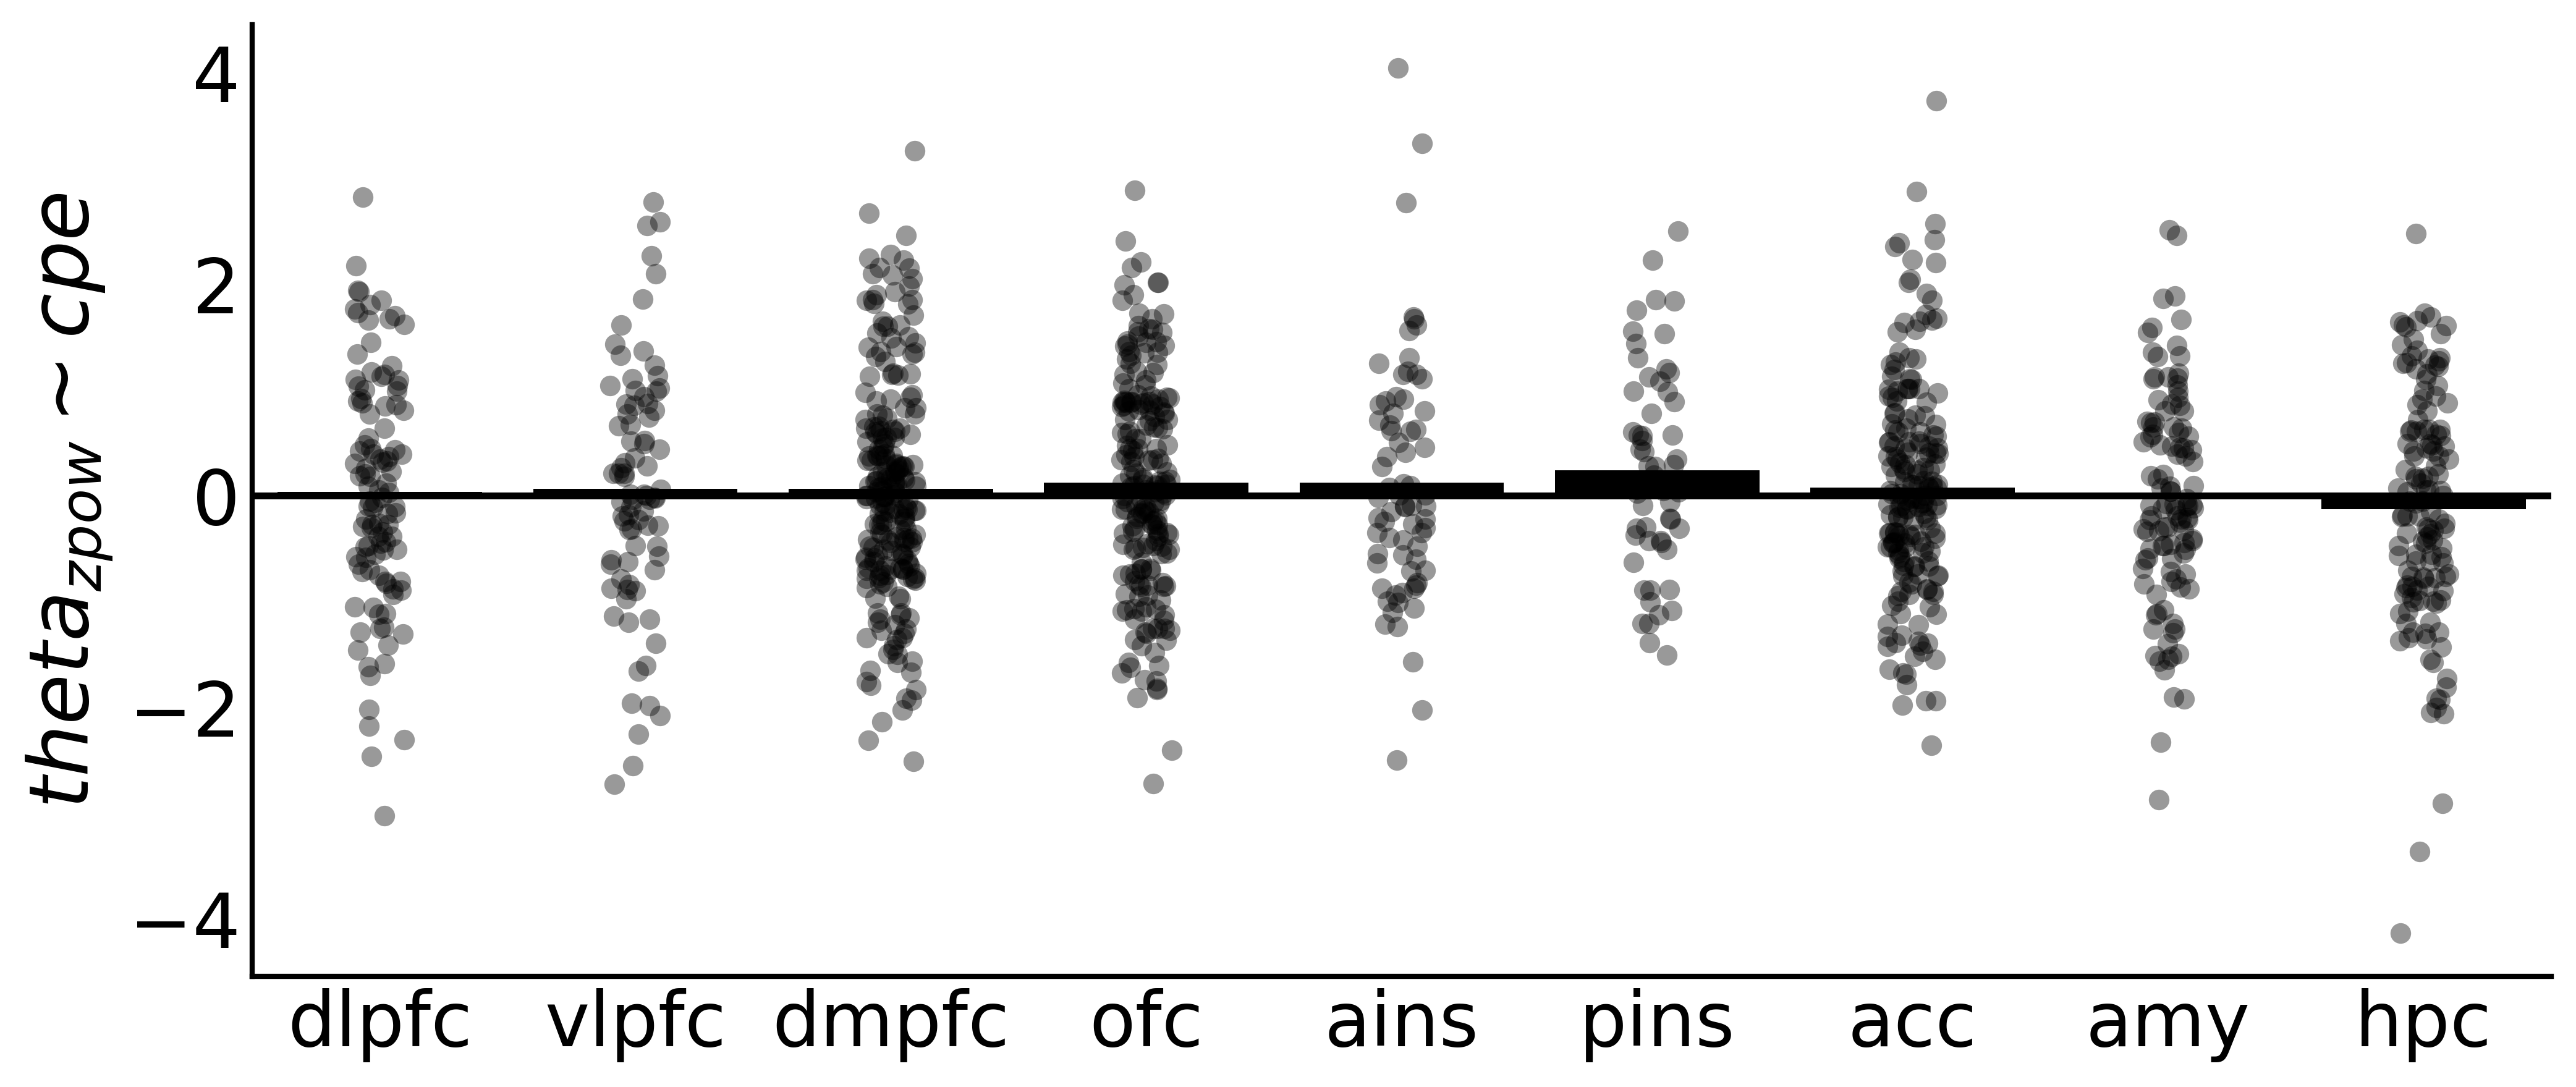

In [28]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim cpe$'


plot_roi_model_results(results,'roi',cpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

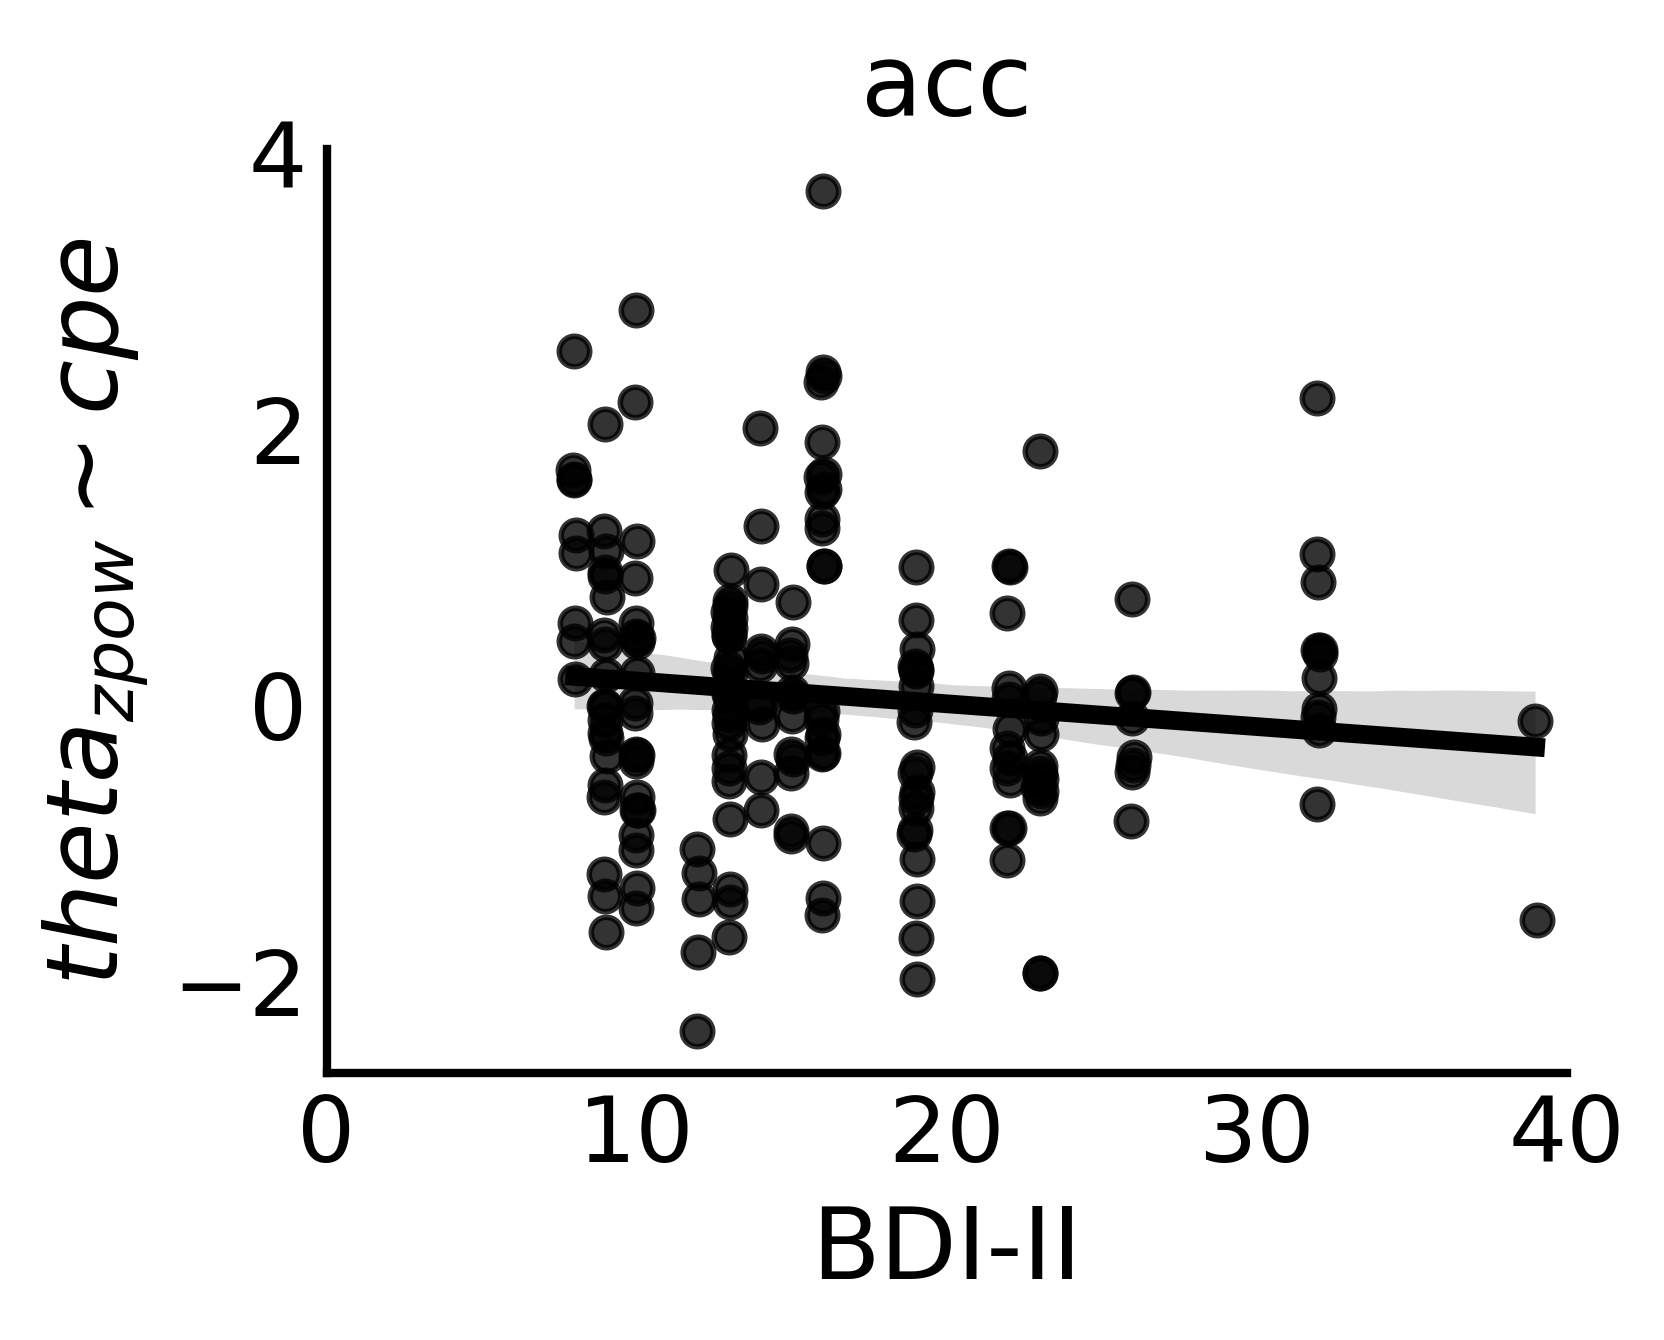

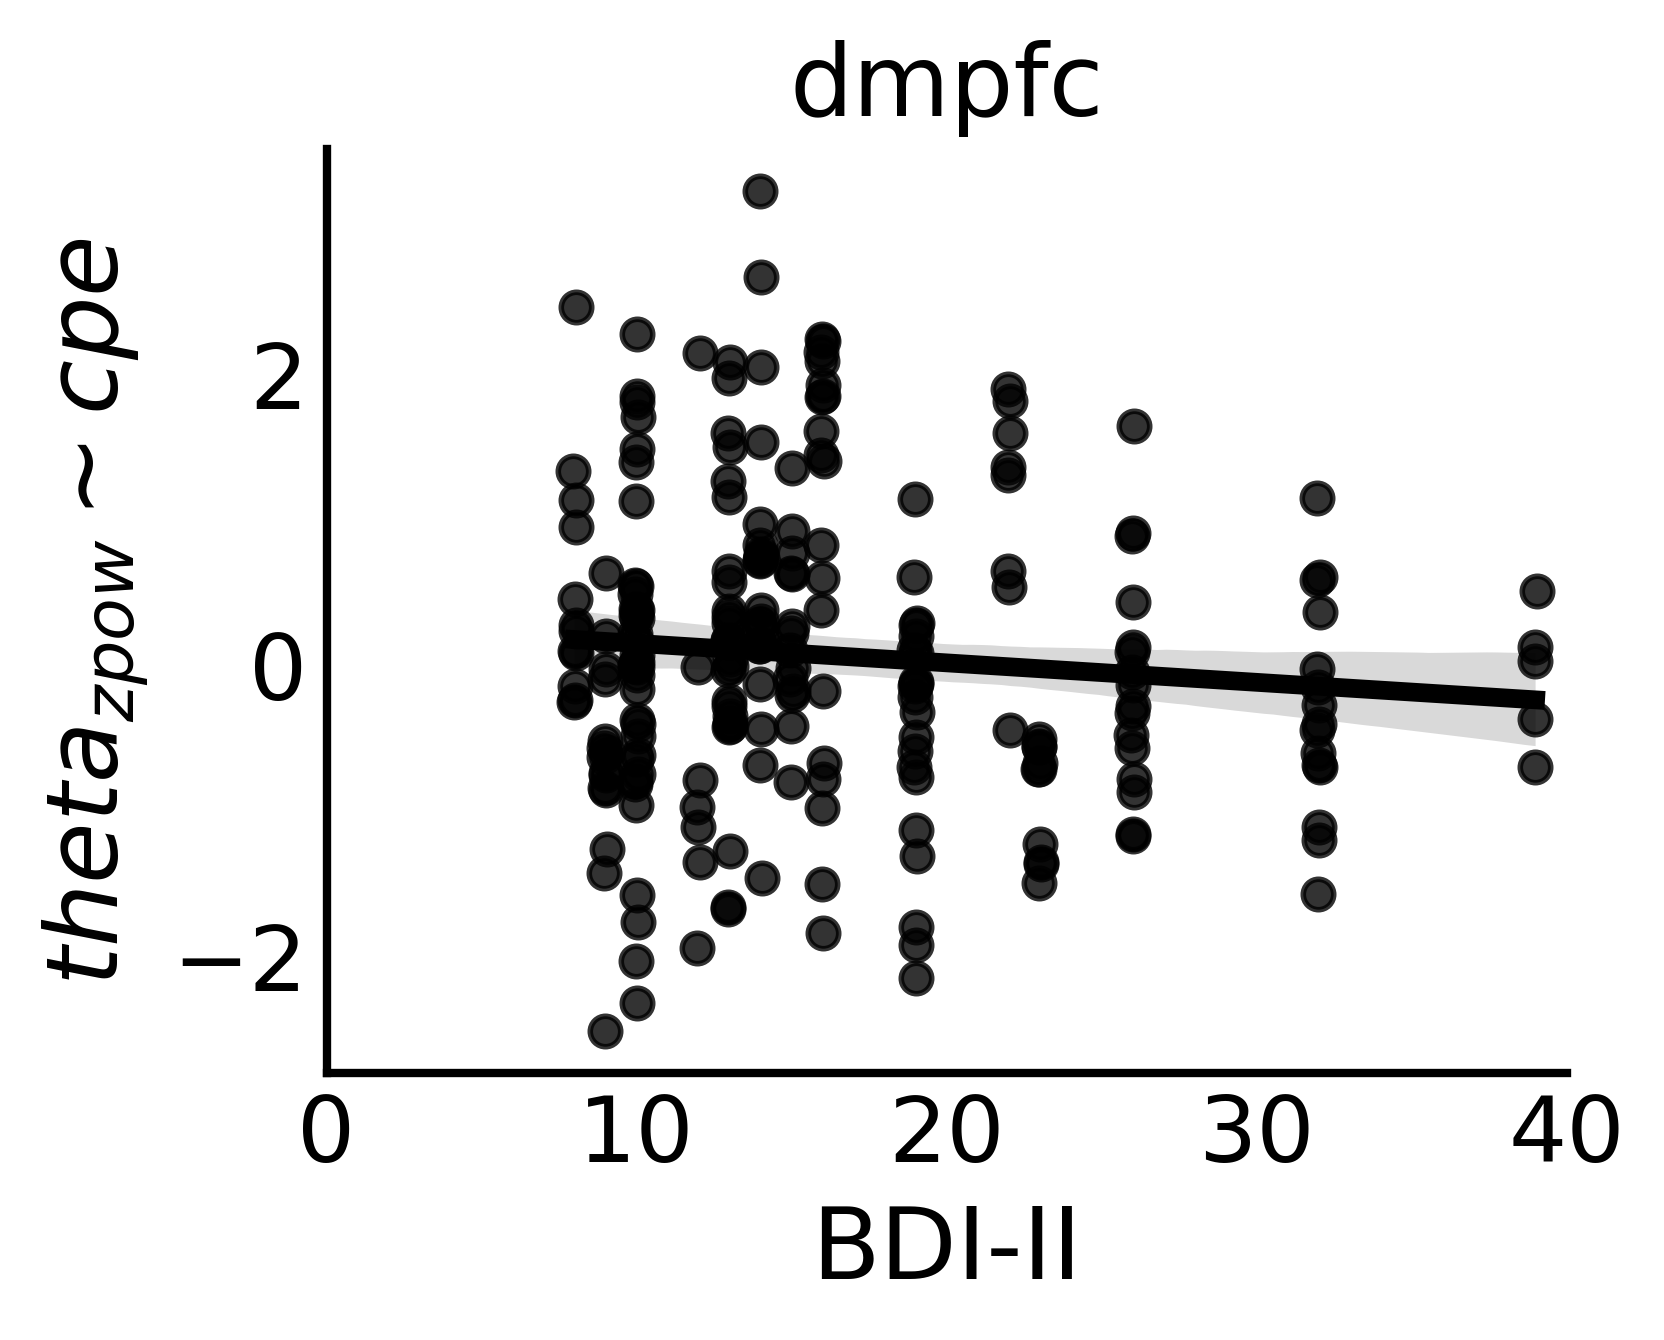

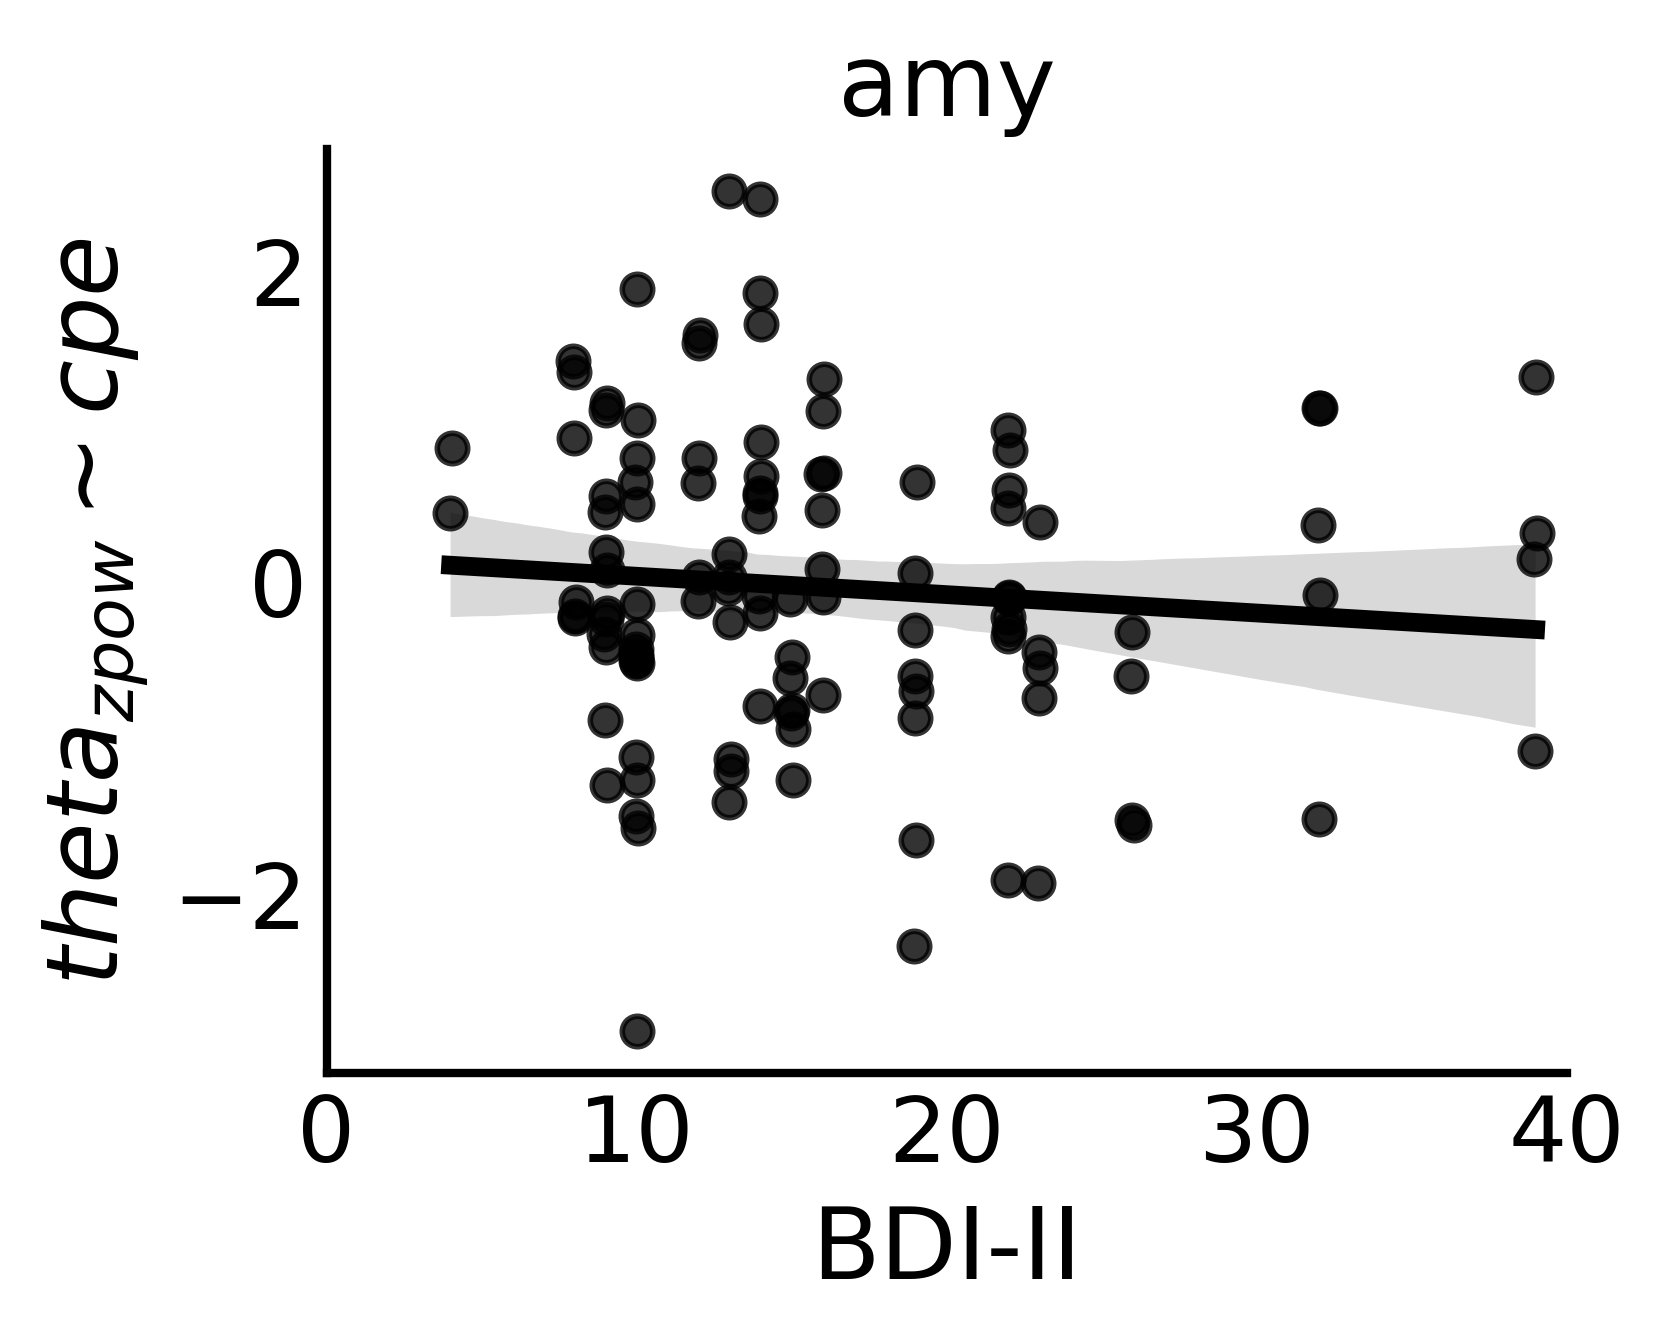

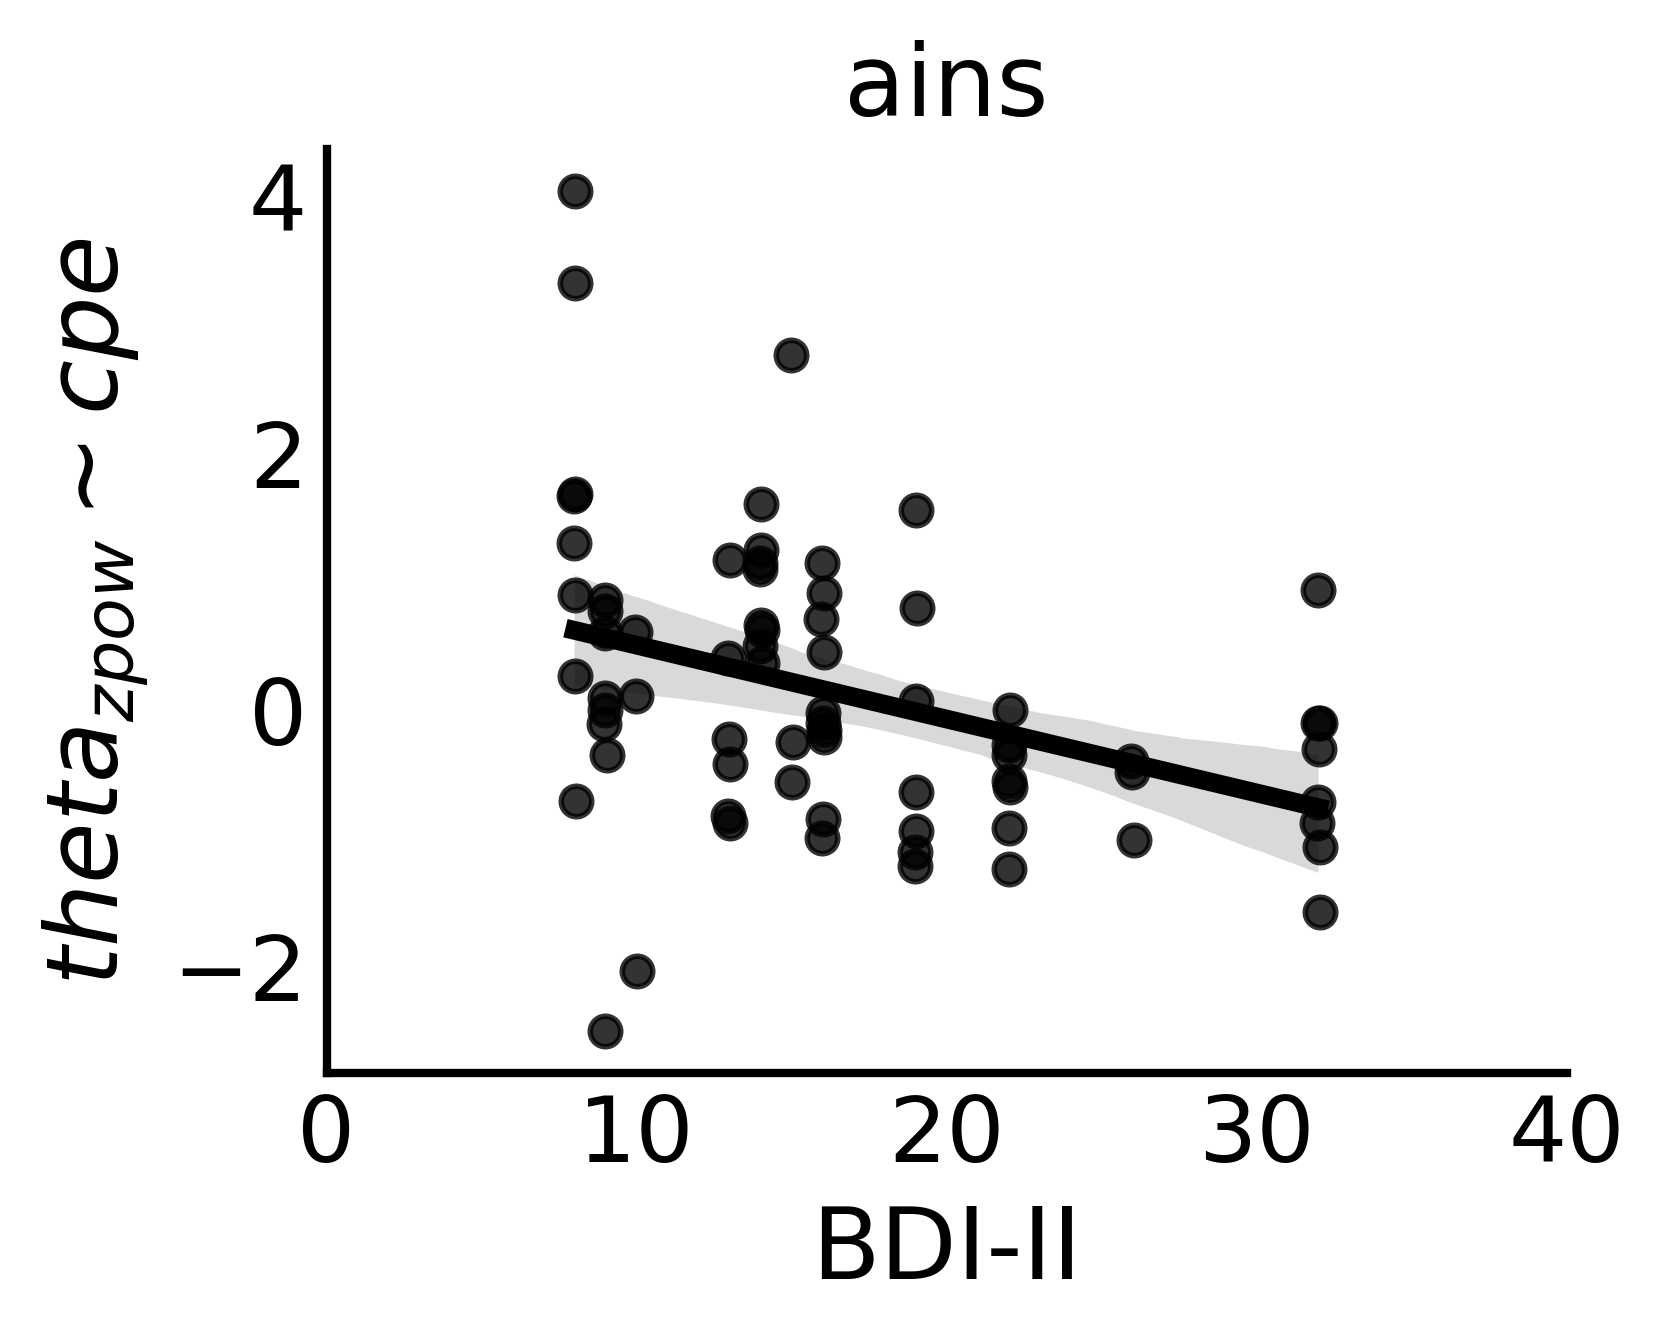

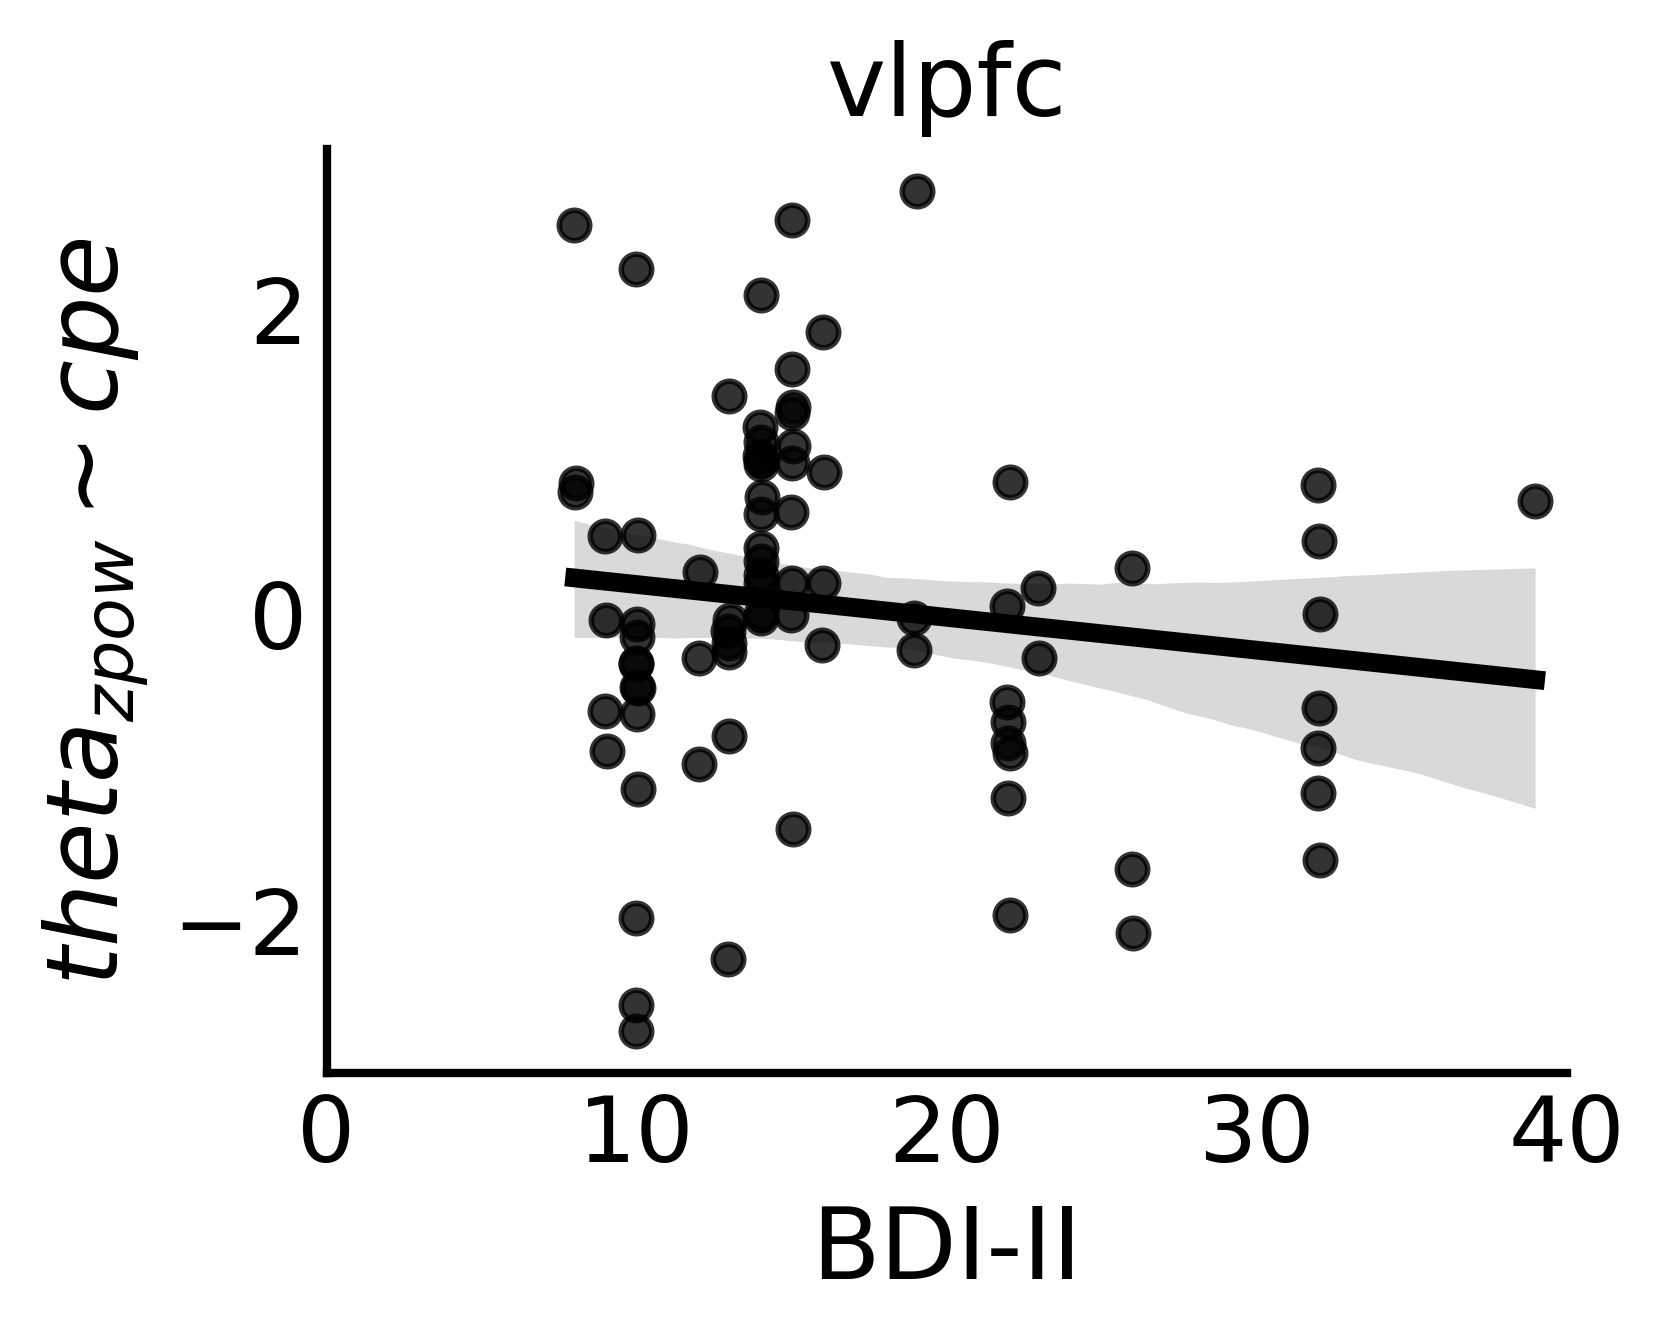

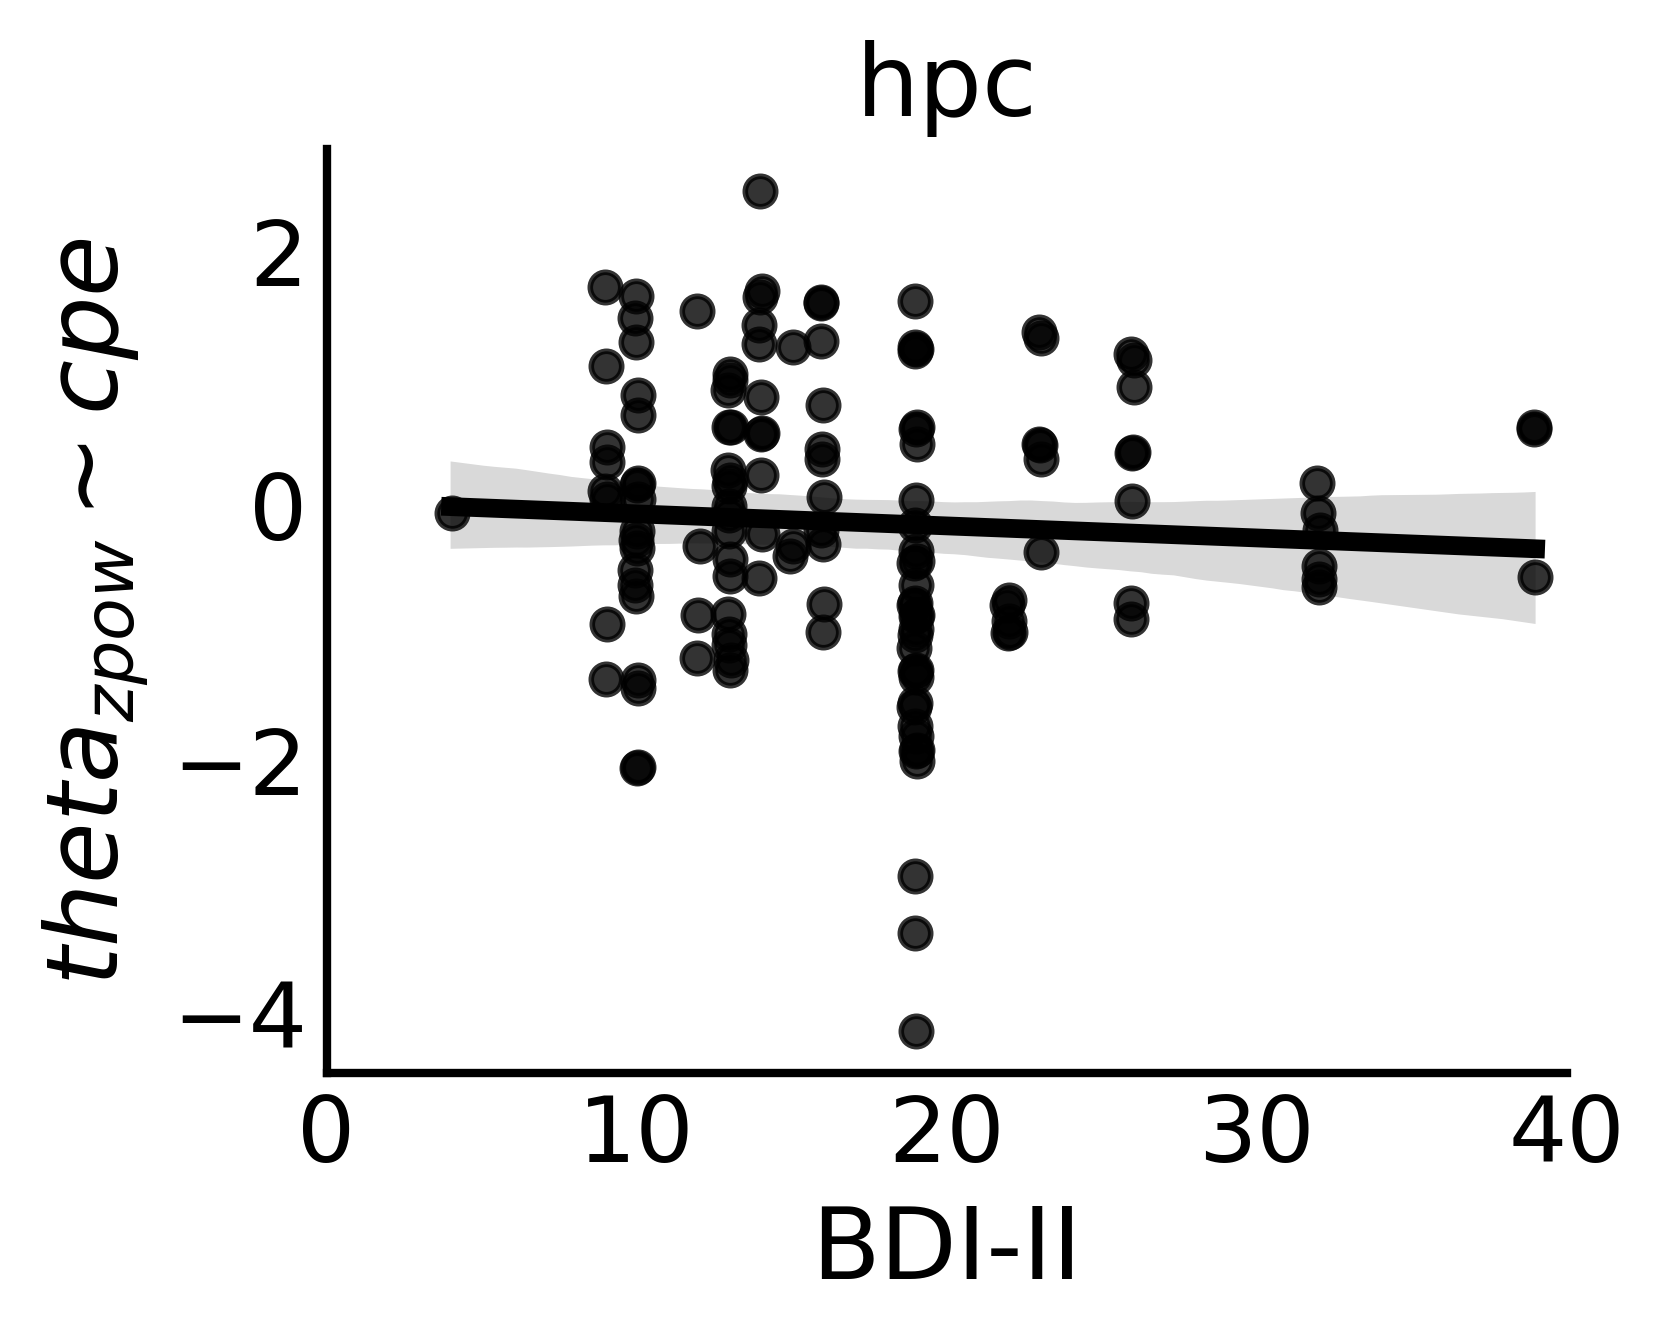

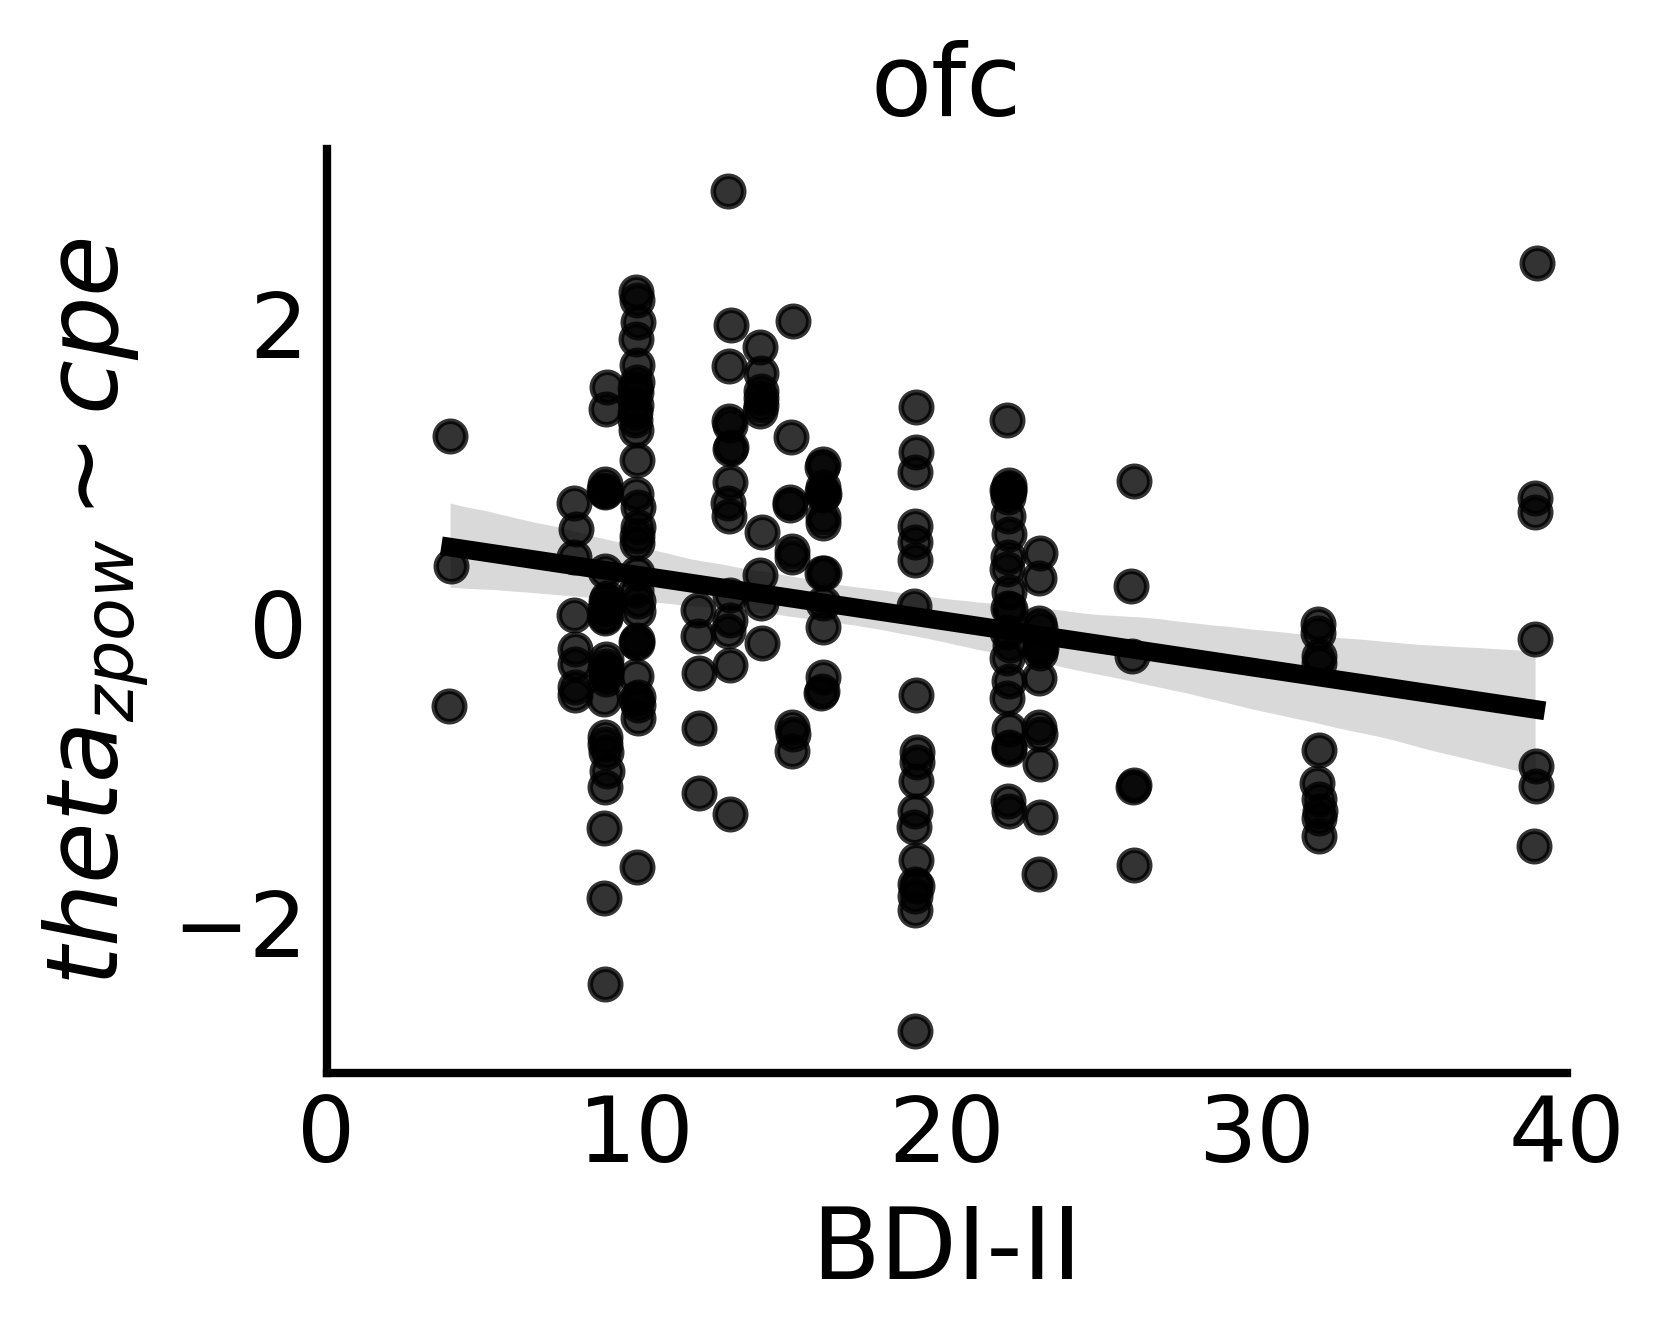

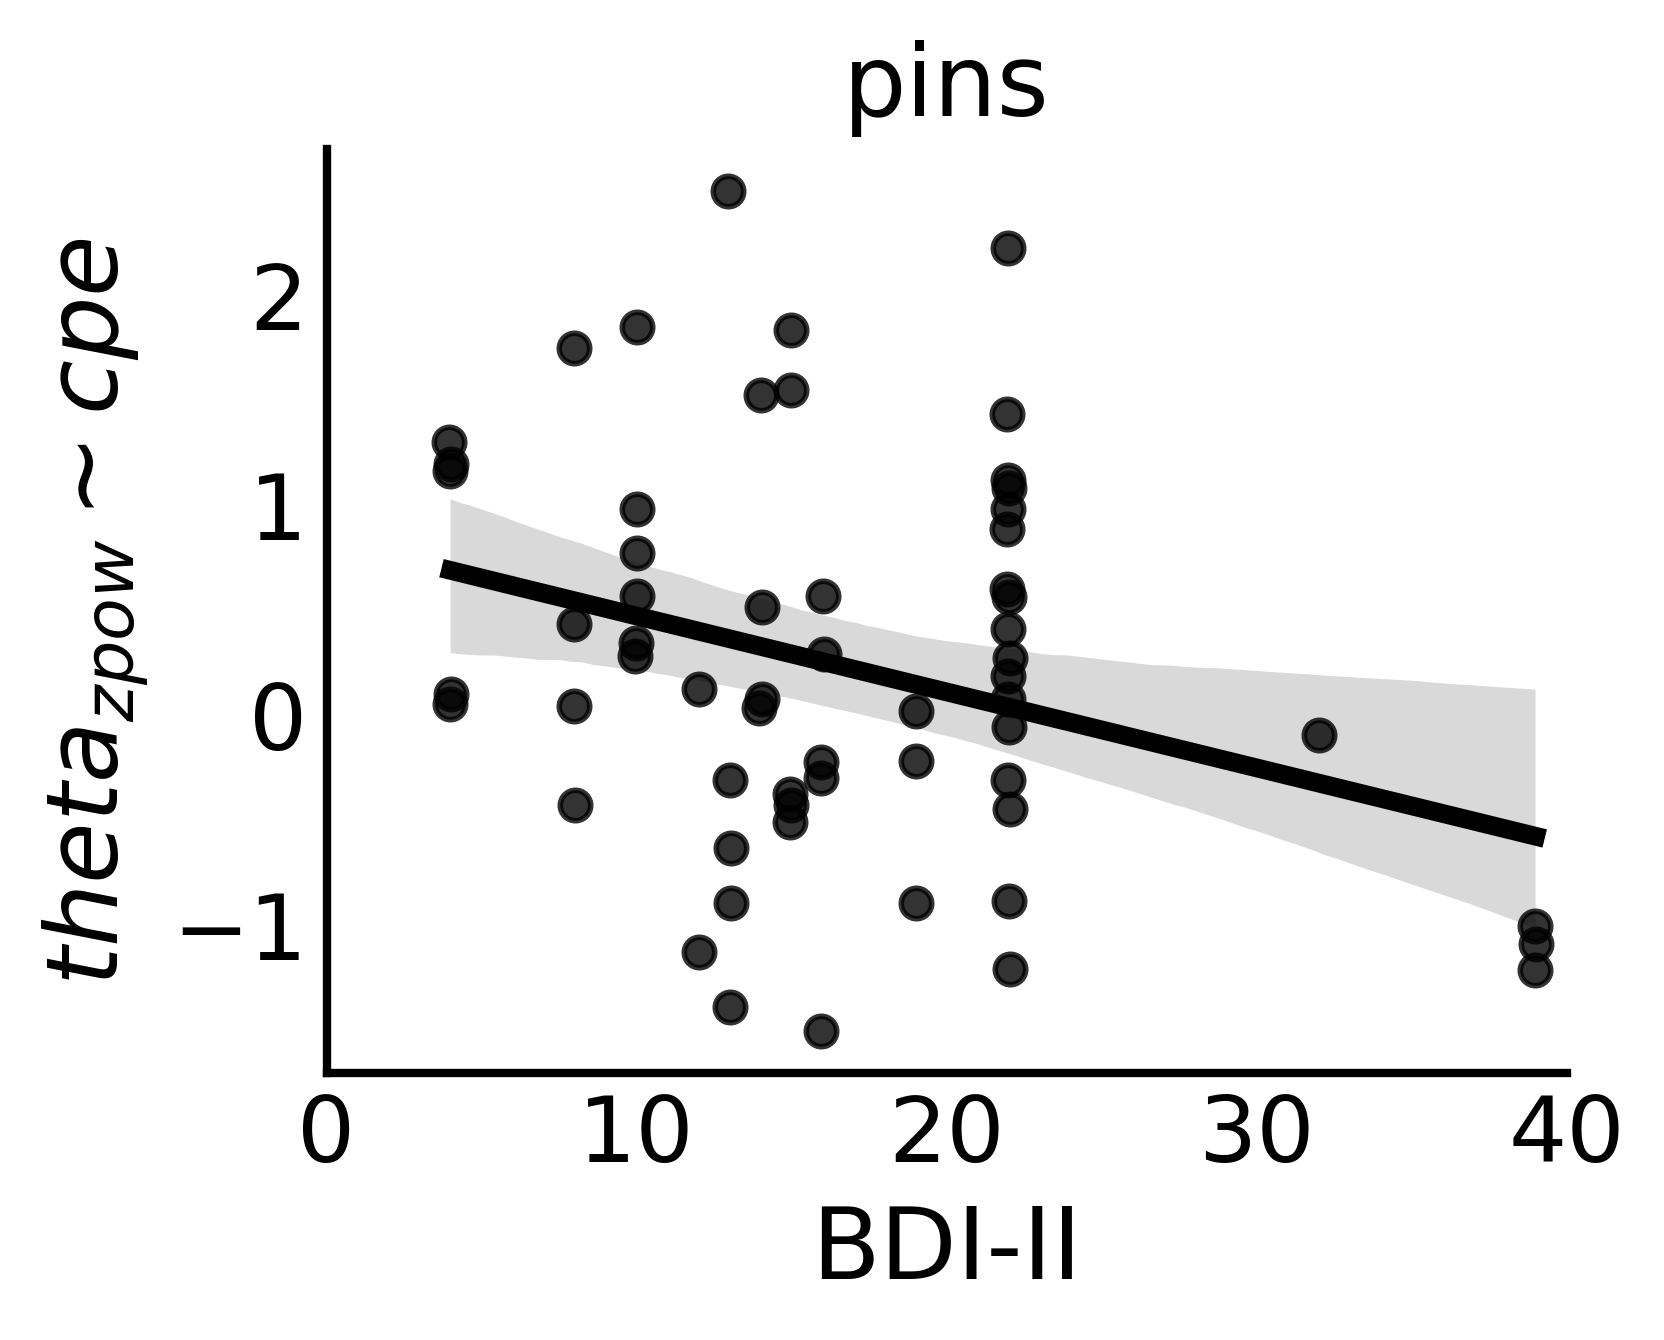

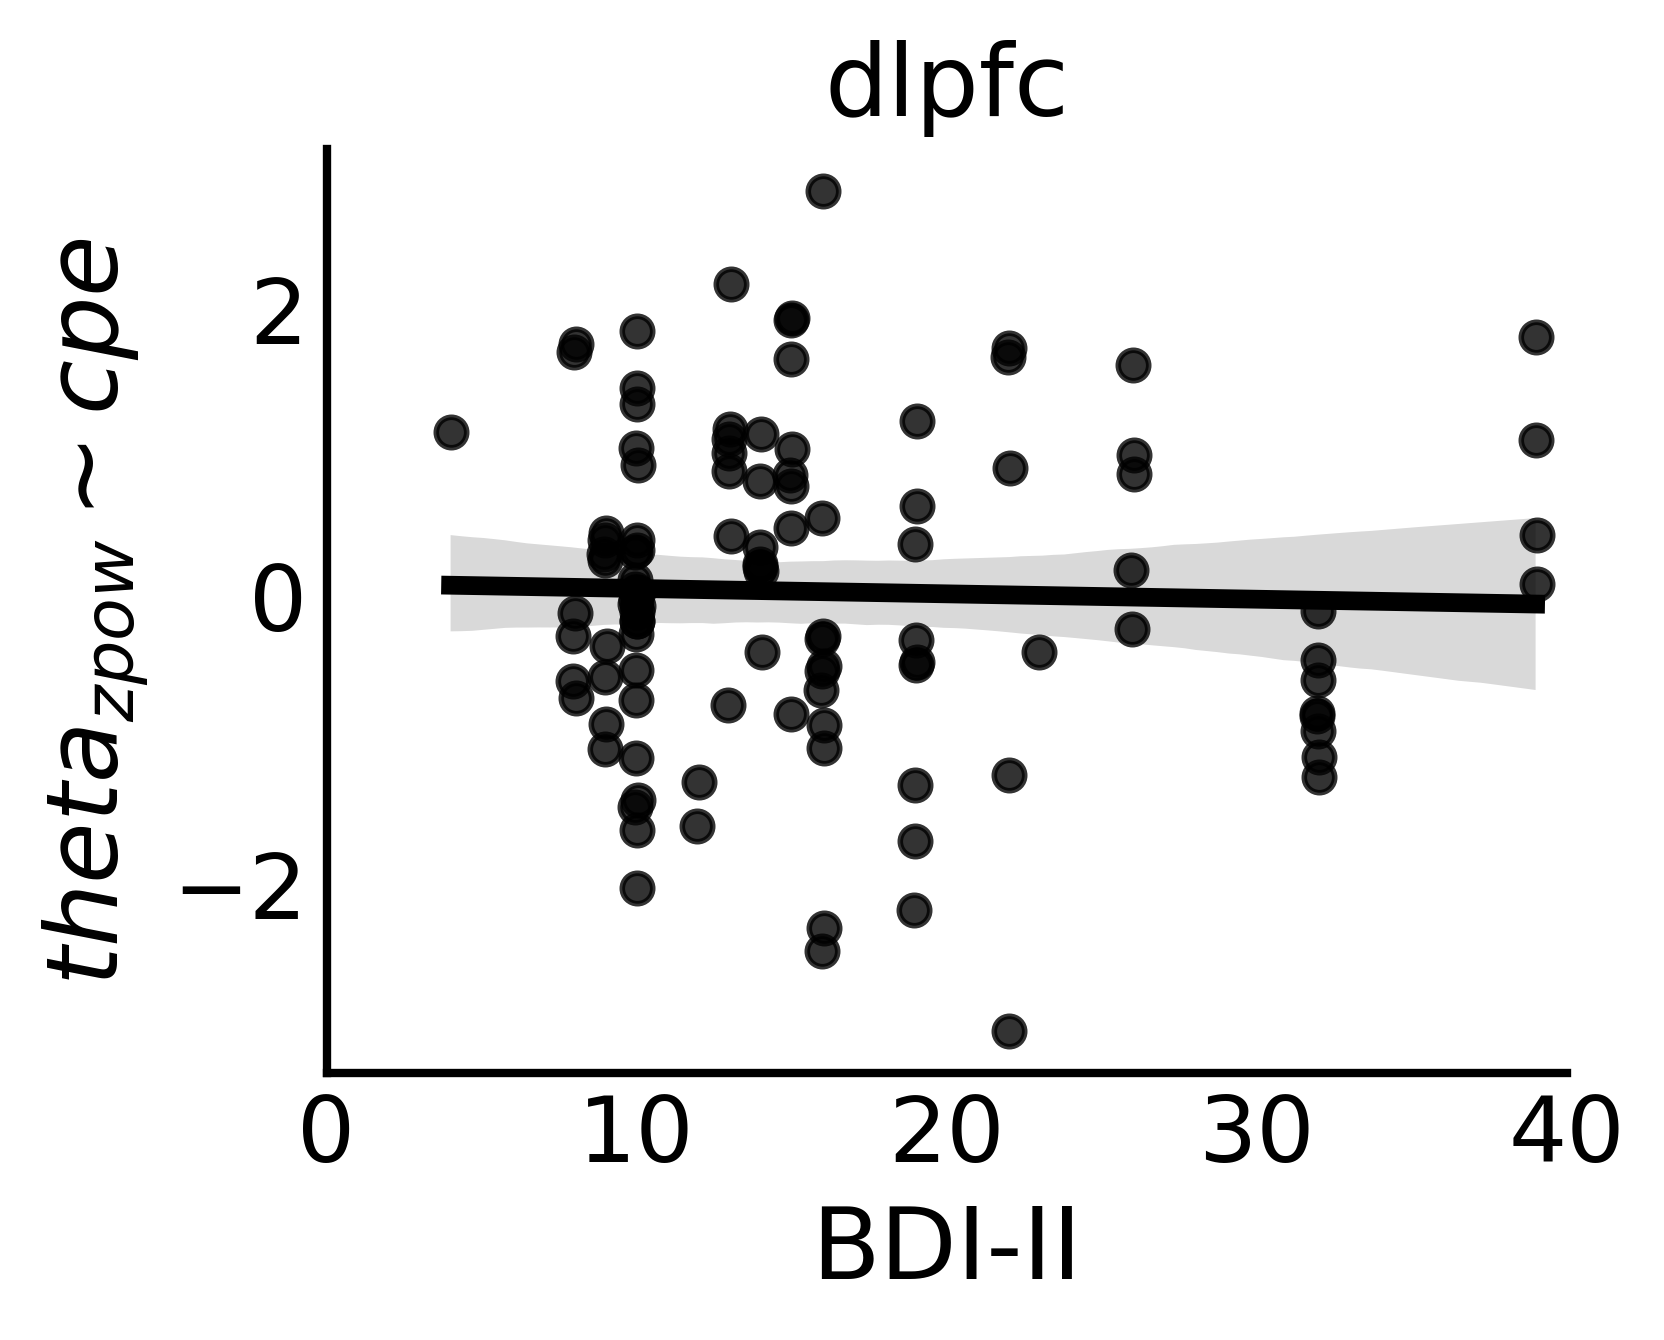

In [29]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_errormodels-bdi_cpe_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [30]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 01 Oct 2024                                         
Time:                        10:52:09                                         
No. Iterations:                    16                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.8568      0.437     36.308     

# RPE Encoding

In [31]:
sig_data = results[results.P_Value_rpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
34    MS002_lmoif9-lmoif10   MS002  vlpfc   14                     0.033294   
51     MS002_racas6-racas7   MS002  dmpfc   14                     0.076611   
57     MS002_ragit3-ragit4   MS002    amy   14                     0.026750   
104    MS003_racas6-racas7   MS003  dmpfc    8                     0.029611   
106    MS003_racas8-racas9   MS003  dmpfc    8                     0.024977   
...                    ...     ...    ...  ...                          ...   
1036   MS048_rmolf4-rmolf5   MS048    ofc   19                    -0.188752   
1038   MS048_rmolf6-rmolf7   MS048    ofc   19                    -0.197583   
1151   DA037_rpins4-rpins5   DA037   pins    4                     0.019546   
1176       DA039_rof5-rof6   DA039    ofc   22                    -0.041695   
1180      DA039_rof9-rof10   DA039  dlpfc   22                     0.024024   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
34                                  0.032518                  -0.005753   
51                                  0.125097                  -0.046057   
57                                 -0.067441                   0.026322   
104                                 0.134976                  -0.105974   
106                                -0.096177                  -0.051585   
...                                      ...                        ...   
1036                                0.047198                  -0.037964   
1038                               -0.032597                   0.001051   
1151                               -0.014659                   0.083679   
1176                                0.000811                  -0.016673   
1180                               -0.069833                   0.095533   

      Original_Estimate_rpe  Original_Estimate_cpe  Permuted_Mean_Intercept  \
34                -0.175021               0.091844                 0.057598   
51                -0.202353               0.323151                 0.161692   
57                -0.152354               0.084304                -0.020589   
104               -0.342694               0.185719                 0.076626   
106               -0.306930               0.301372                -0.007009   
...                     ...                    ...                      ...   
1036               0.179976              -0.148008                -0.165146   
1038               0.076196              -0.067863                -0.215517   
1151              -0.255254               0.147991                 0.018877   
1176              -0.248350               0.082877                -0.036951   
1180               0.198197              -0.114655                -0.000267   

      ...  Z_Score_TrialEV  Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
34    ...        -0.052288    -2.124377     1.039216           0.691338   
51    ...        -0.566835    -2.037293     3.256744           0.216934   
57    ...         0.588422    -3.095855     1.664405           0.160633   
104   ...        -1.289420    -2.433943     1.339049           0.116508   
106   ...        -0.725714    -2.555187     2.459486           0.240264   
...   ...              ...          ...          ...                ...   
1036  ...        -0.592867     2.188560    -1.822329           0.475246   
1038  ...         0.019316     2.158249    -1.913028           0.254539   
1151  ...         0.980185    -2.019679     1.162574           0.976879   
1176  ...        -0.147287    -2.109561     0.715406           0.906173   
1180  ...         1.275252     2.083308    -1.243764           0.485101   

      P_Value_GambleChoice[T.safe]  P_Value_TrialEV  P_Value_rpe  P_Value_cpe  \
34                        0.685464         0.958299     0.033639     0.298704   
51                        0.207586         0.570826     0.041621     0.001127   
57                        0.163299         0.556249     0.001962     

In [32]:
sig_data.roi.value_counts()



roi
ofc      17
dmpfc    16
acc      12
vlpfc     6
amy       6
ains      5
dlpfc     5
hpc       5
pins      3
Name: count, dtype: int64

In [33]:
sig_data.roi.unique()



array(['vlpfc', 'dmpfc', 'amy', 'ains', 'acc', 'ofc', 'dlpfc', 'hpc',
       'pins'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [34]:
# add mask col for sig cpe elecs 
results['rpe_sig']   = results['P_Value_rpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.177691   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.032339   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.101434   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.077311   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.152573   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.120153                  -0.013360   
1                                0.091045                  -0.006864   
2                                0.024729                  -0.128693   
3                                0.029243                   0.140855   
4                                0.040784                   0.043473   

   Original_Estimate_rpe  Original_Estimate_cpe  Permuted_Mean_Intercept  ...  \
0               0.046913              -0.001751                 0.095110  ...   
1               0.086592               0.032314                 0.098980  ...   
2              -0.093847               0.005218                 0.115490  ...   
3              -0.143319               0.080736                 0.097071  ...   
4              -0.045996               0.032263                 0.178940  ...   

   Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  P_Value_GambleChoice[T.safe]  \
0     0.545037     0.017530           0.138593                      0.138384   
1     0.893400     0.361813           0.321174                      0.319385   
2    -1.141438    -0.010664           0.803185                      0.796872   
3    -1.472861     0.881312           0.753508                      0.754092   
4    -0.471400     0.294361           0.685264                      0.685250   

   P_Value_TrialEV  P_Value_rpe  P_Value_cpe  cpe_sig  bdi_split  rpe_sig  
0         0.892042     0.585728     0.986014        0          0        0  
1         0.943887     0.371643     0.717492        0          0        0  
2         0.077869     0.253688     0.991491        0          0        0  
3         0.087728     0.140788     0.378149        0          0        0  
4         0.604613     0.637355     0.768482        0          0        0  

[5 rows x 32 columns]

In [35]:
rpe_var = 'Z_Score_rpe'

In [36]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [37]:
results.groupby('roi').agg('mean',numeric_only=True)[rpe_var][bar_order]



roi
dlpfc   -0.030114
vlpfc   -0.123820
dmpfc   -0.145857
ofc     -0.351928
ains     0.181876
pins    -0.062221
acc      0.119112
amy      0.146507
hpc     -0.139892
Name: Z_Score_rpe, dtype: float64

In [38]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[rpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.rpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].rpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [39]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     12  0.062176              2    1.547466  1.233977e-01   
1  dmpfc      225     16  0.071111              5   -2.049484  4.157988e-02   
2    amy      113      6  0.053097              1    1.491593  1.386171e-01   
3   ains       71      5  0.070423              0    1.375247  1.734404e-01   
4  vlpfc       82      6  0.073171              0   -1.015819  3.127404e-01   
5    hpc      135      5  0.037037              0   -1.796873  7.460821e-02   
6    ofc      202     17  0.084158              7   -5.110202  7.464417e-07   
7   pins       60      3  0.050000              1   -0.470121  6.400018e-01   
8  dlpfc      107      5  0.046729              1   -0.294061  7.692866e-01   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.036265            1.0    0.062176      0.2603  
1      0.045110            1.0    0.071111      0.1009  
2      0.023374            1.0    0.053097      0.4994  
3      0.028157            1.0    0.070423      0.2818  
4      0.032344            1.0    0.073171      0.2269  
5      0.014705            1.0    0.037037      0.8101  
6      0.054333            1.0    0.084158      0.0259  
7      0.013765            1.0    0.050000      0.5826  
8      0.018591            1.0    0.046729      0.6243

In [40]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
6  ofc      202     17  0.084158              7   -5.110202  7.464417e-07   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
6      0.054333            1.0    0.084158      0.0259

# Plot Results

In [41]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_errormodels-rpe_coeff_barplot_{epoch_len}.pdf'


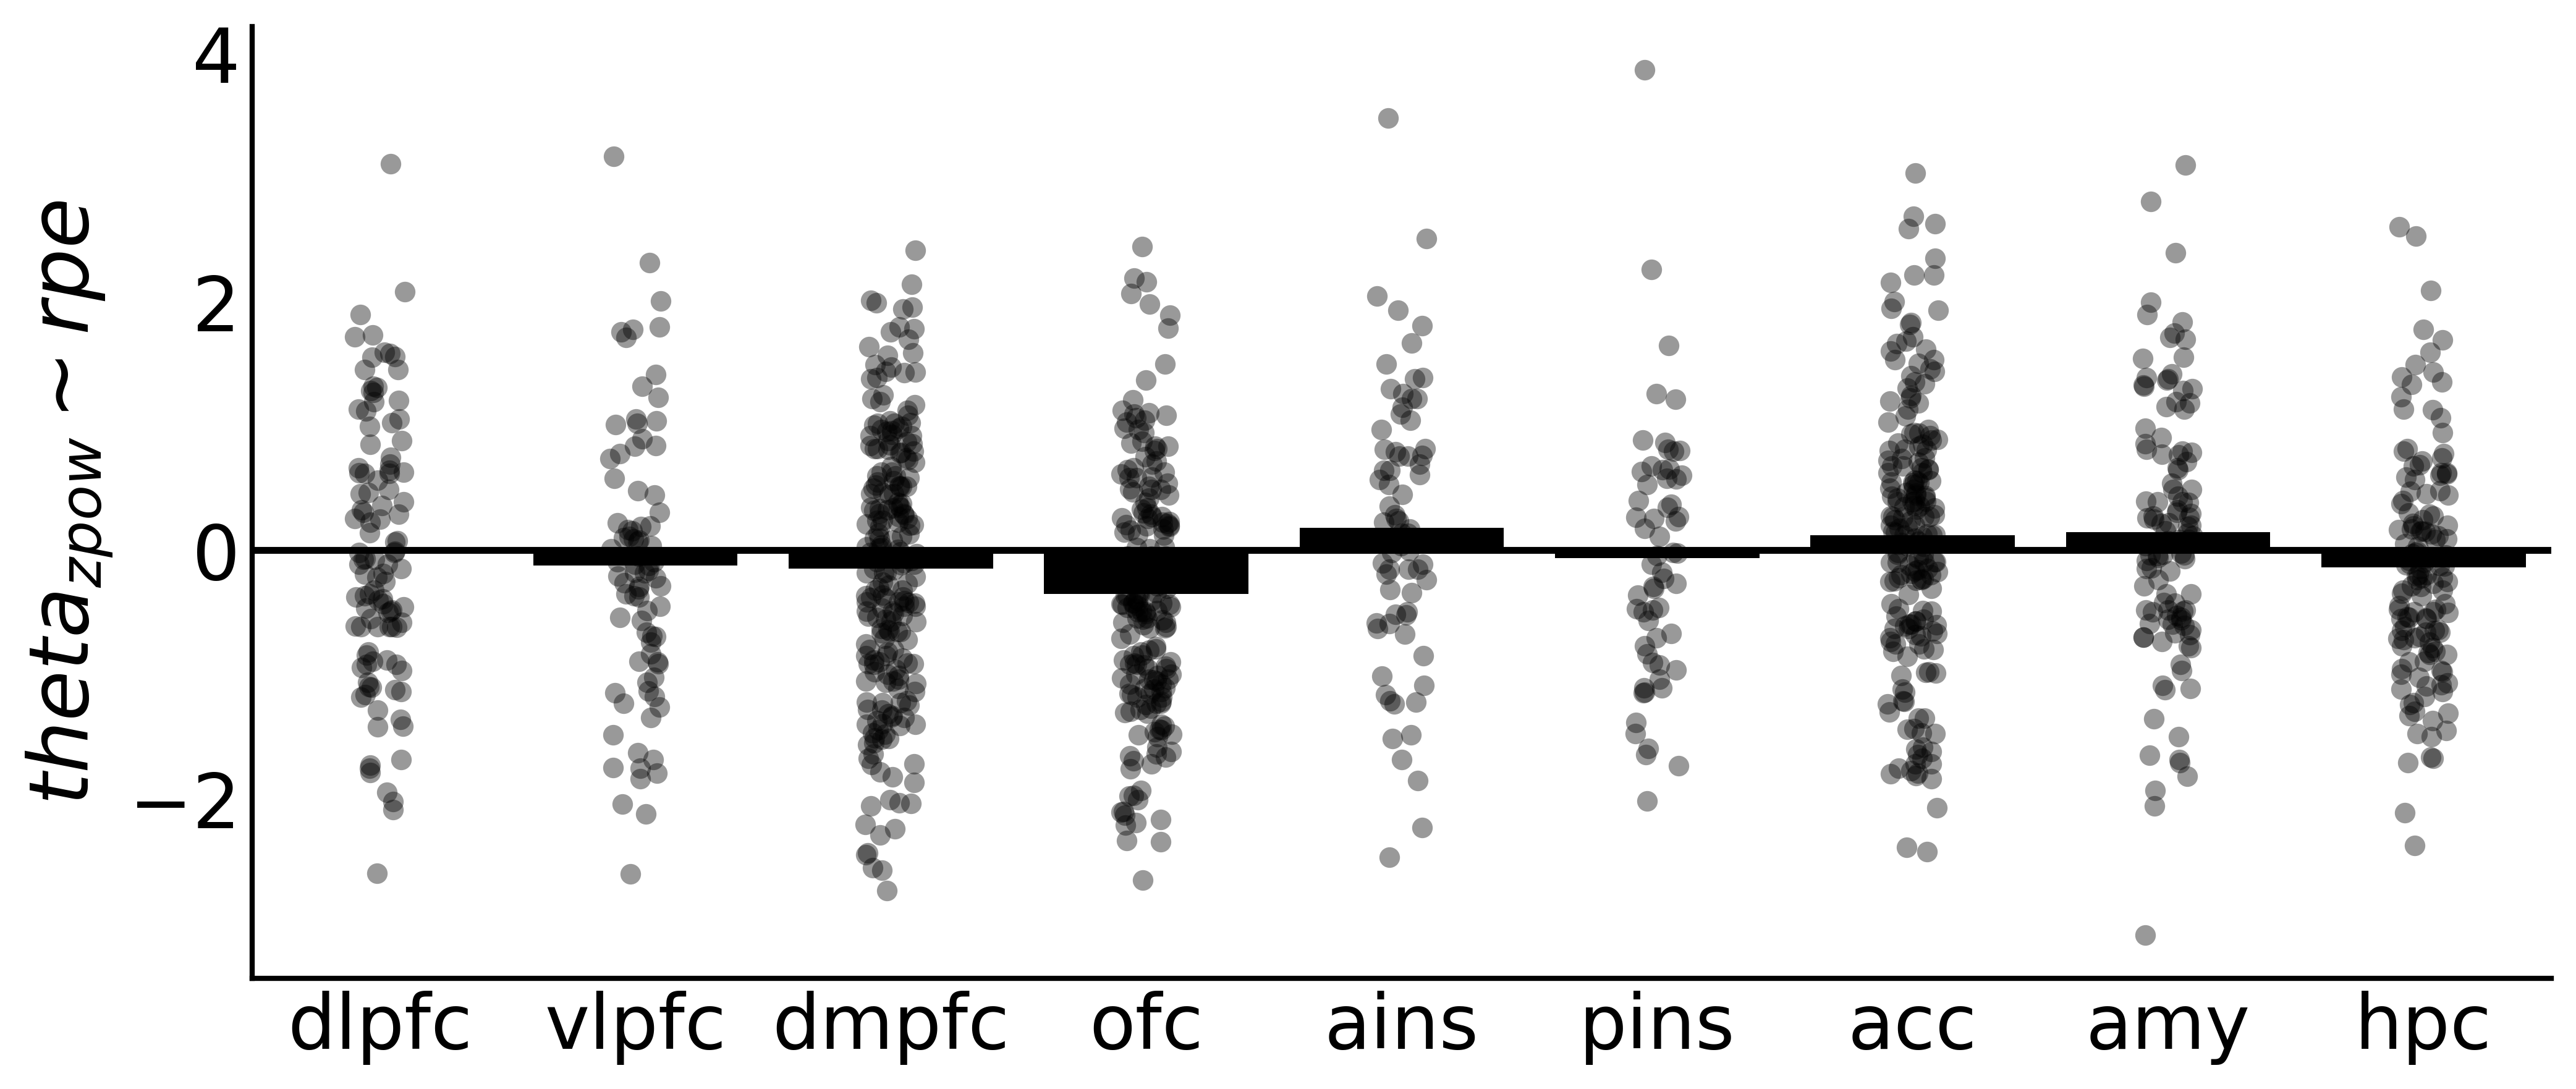

In [42]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim rpe$'


plot_roi_model_results(results,'roi',rpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

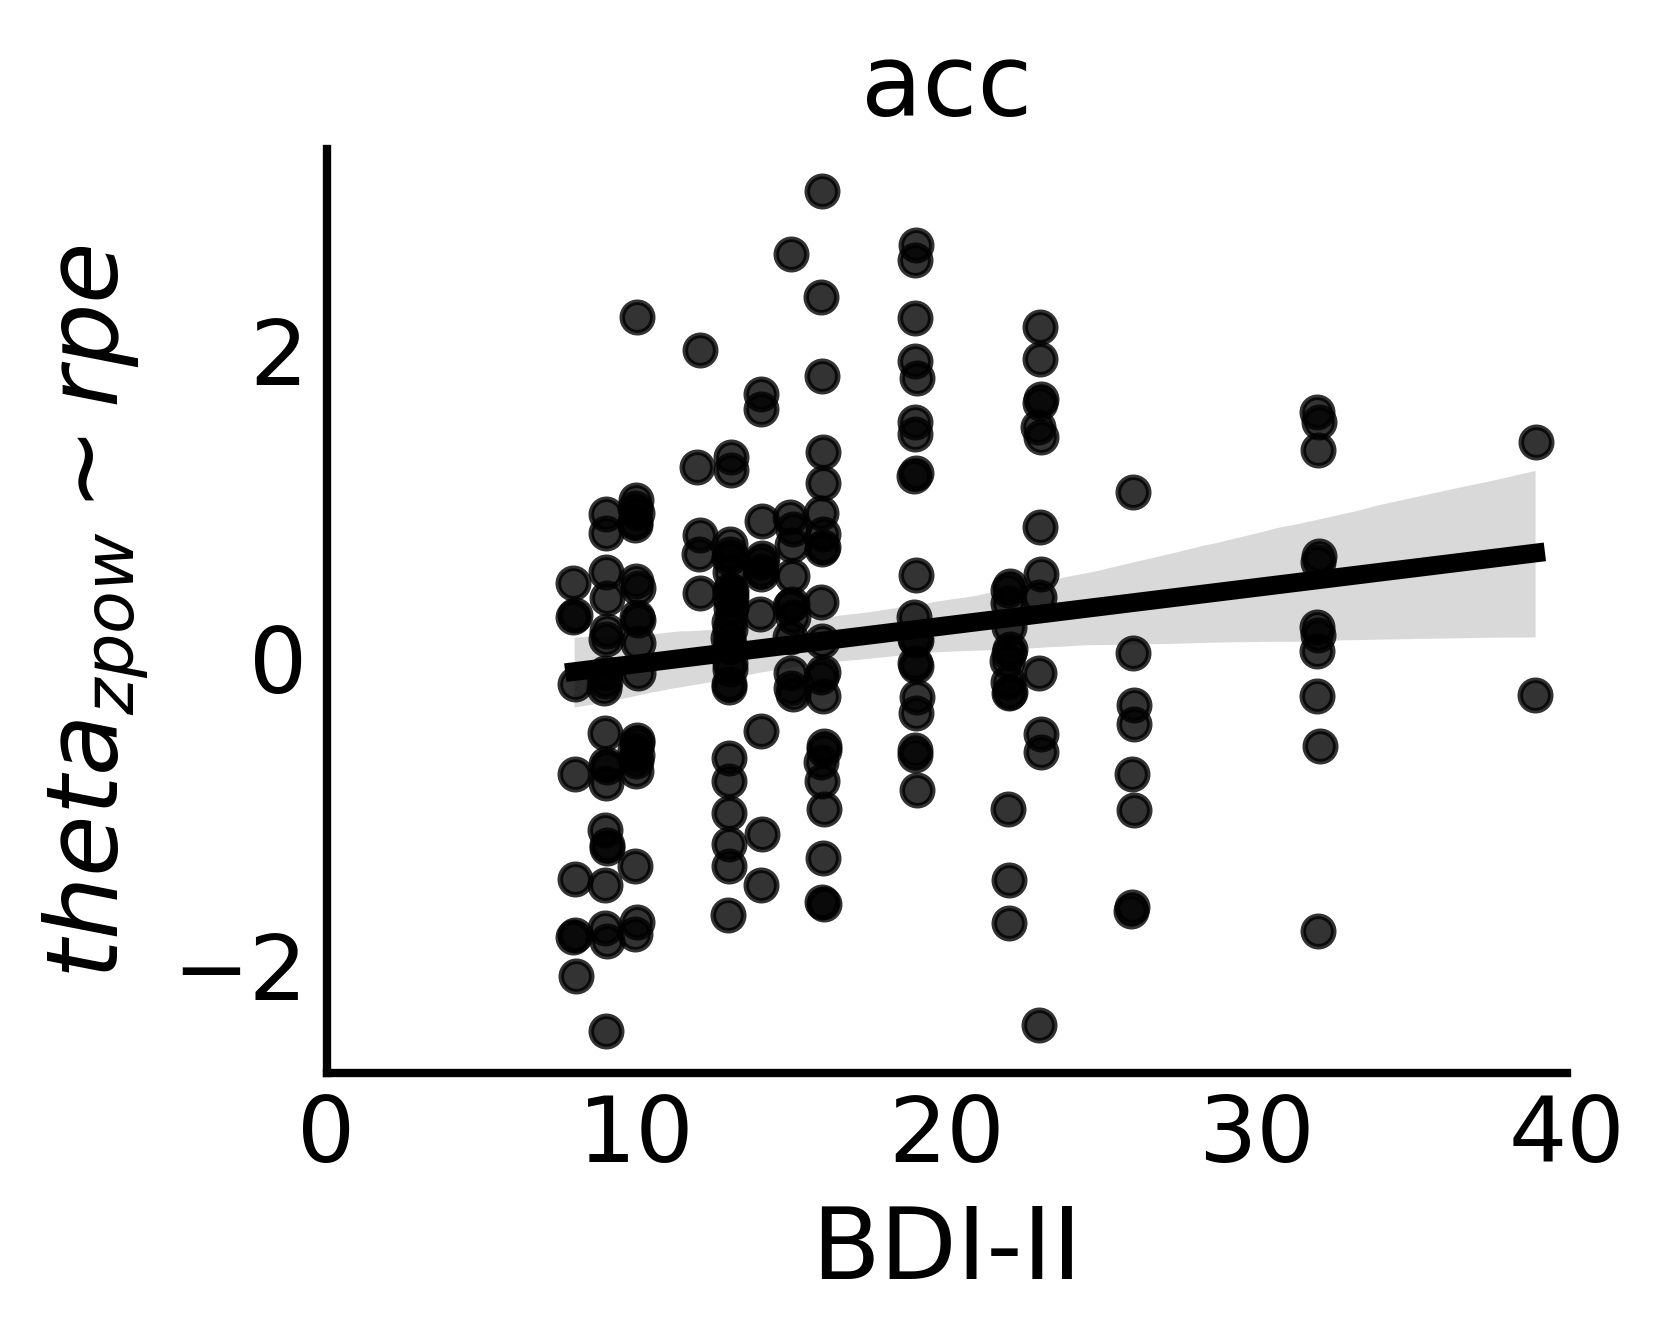

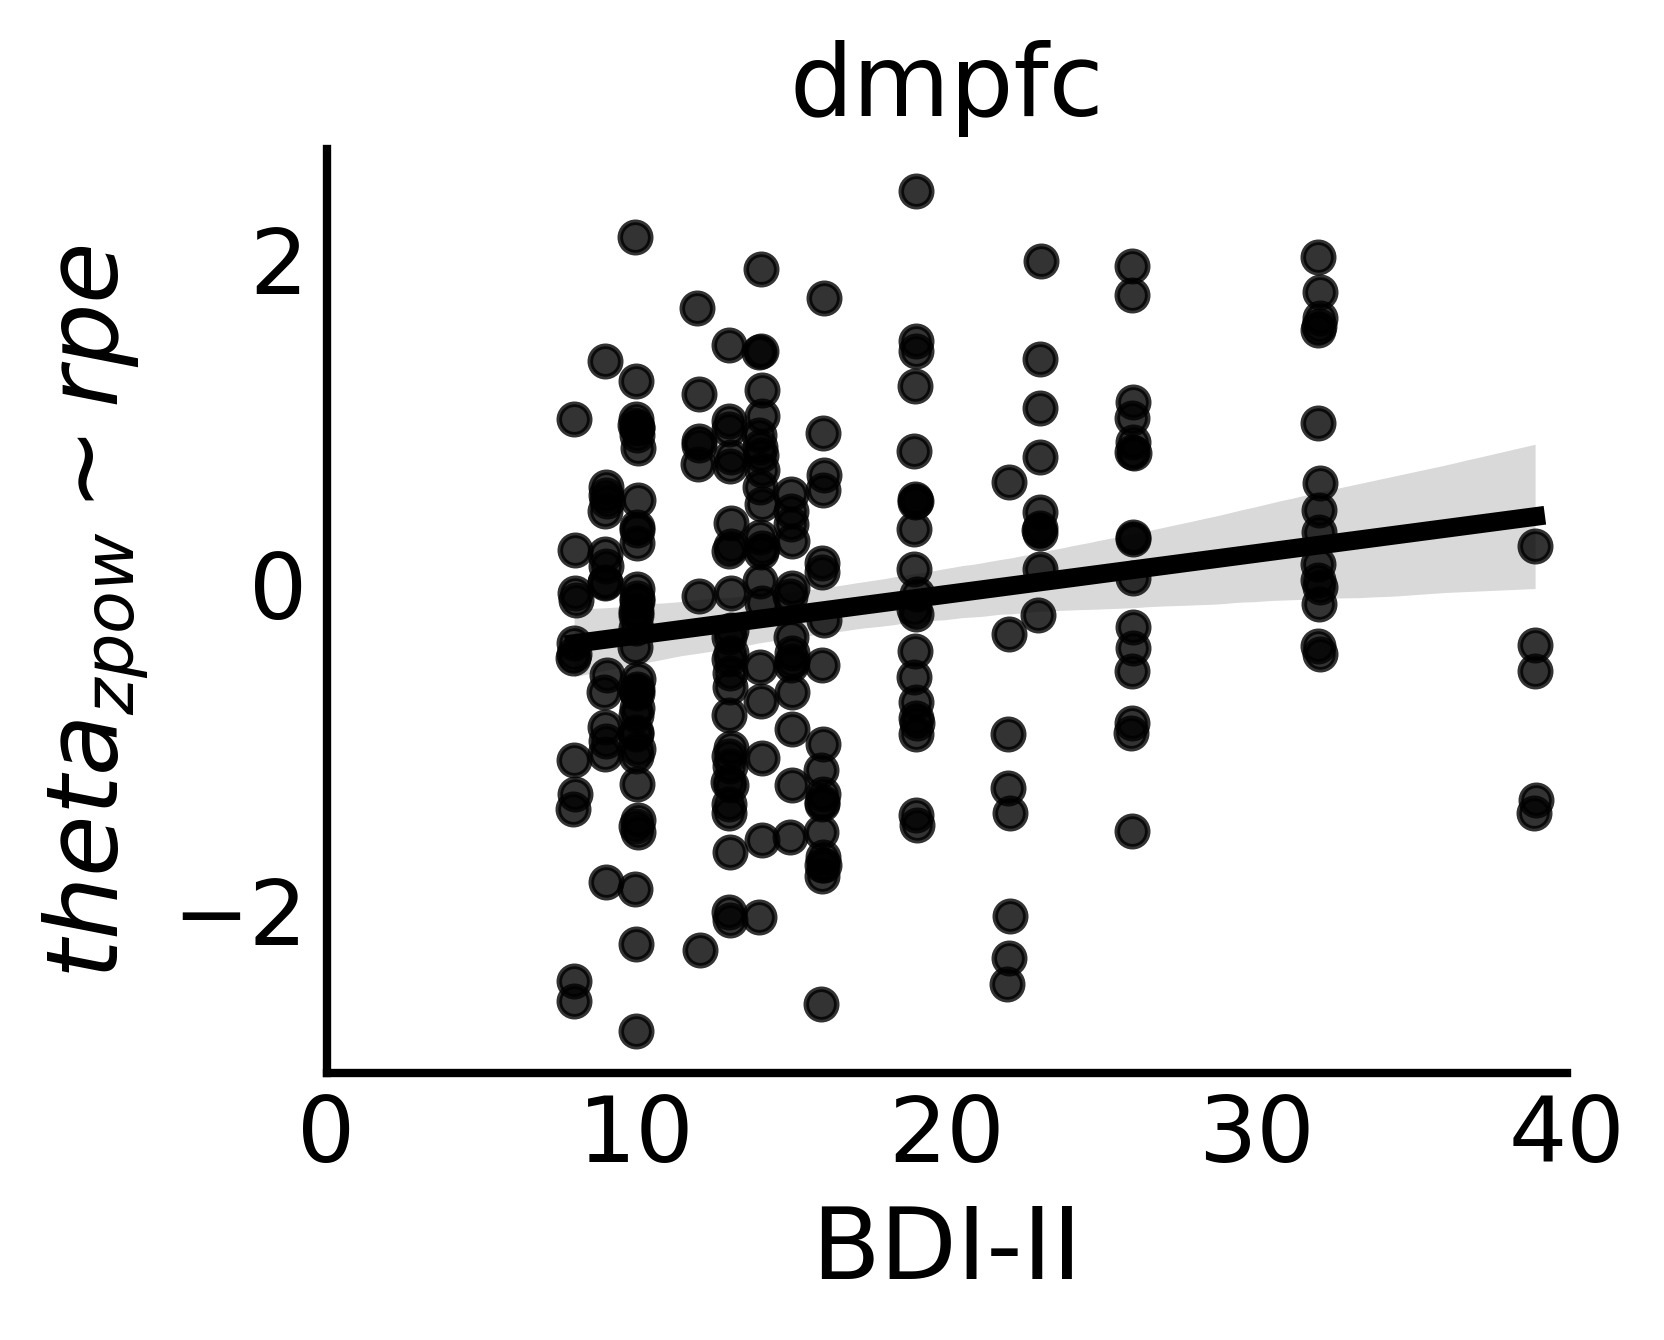

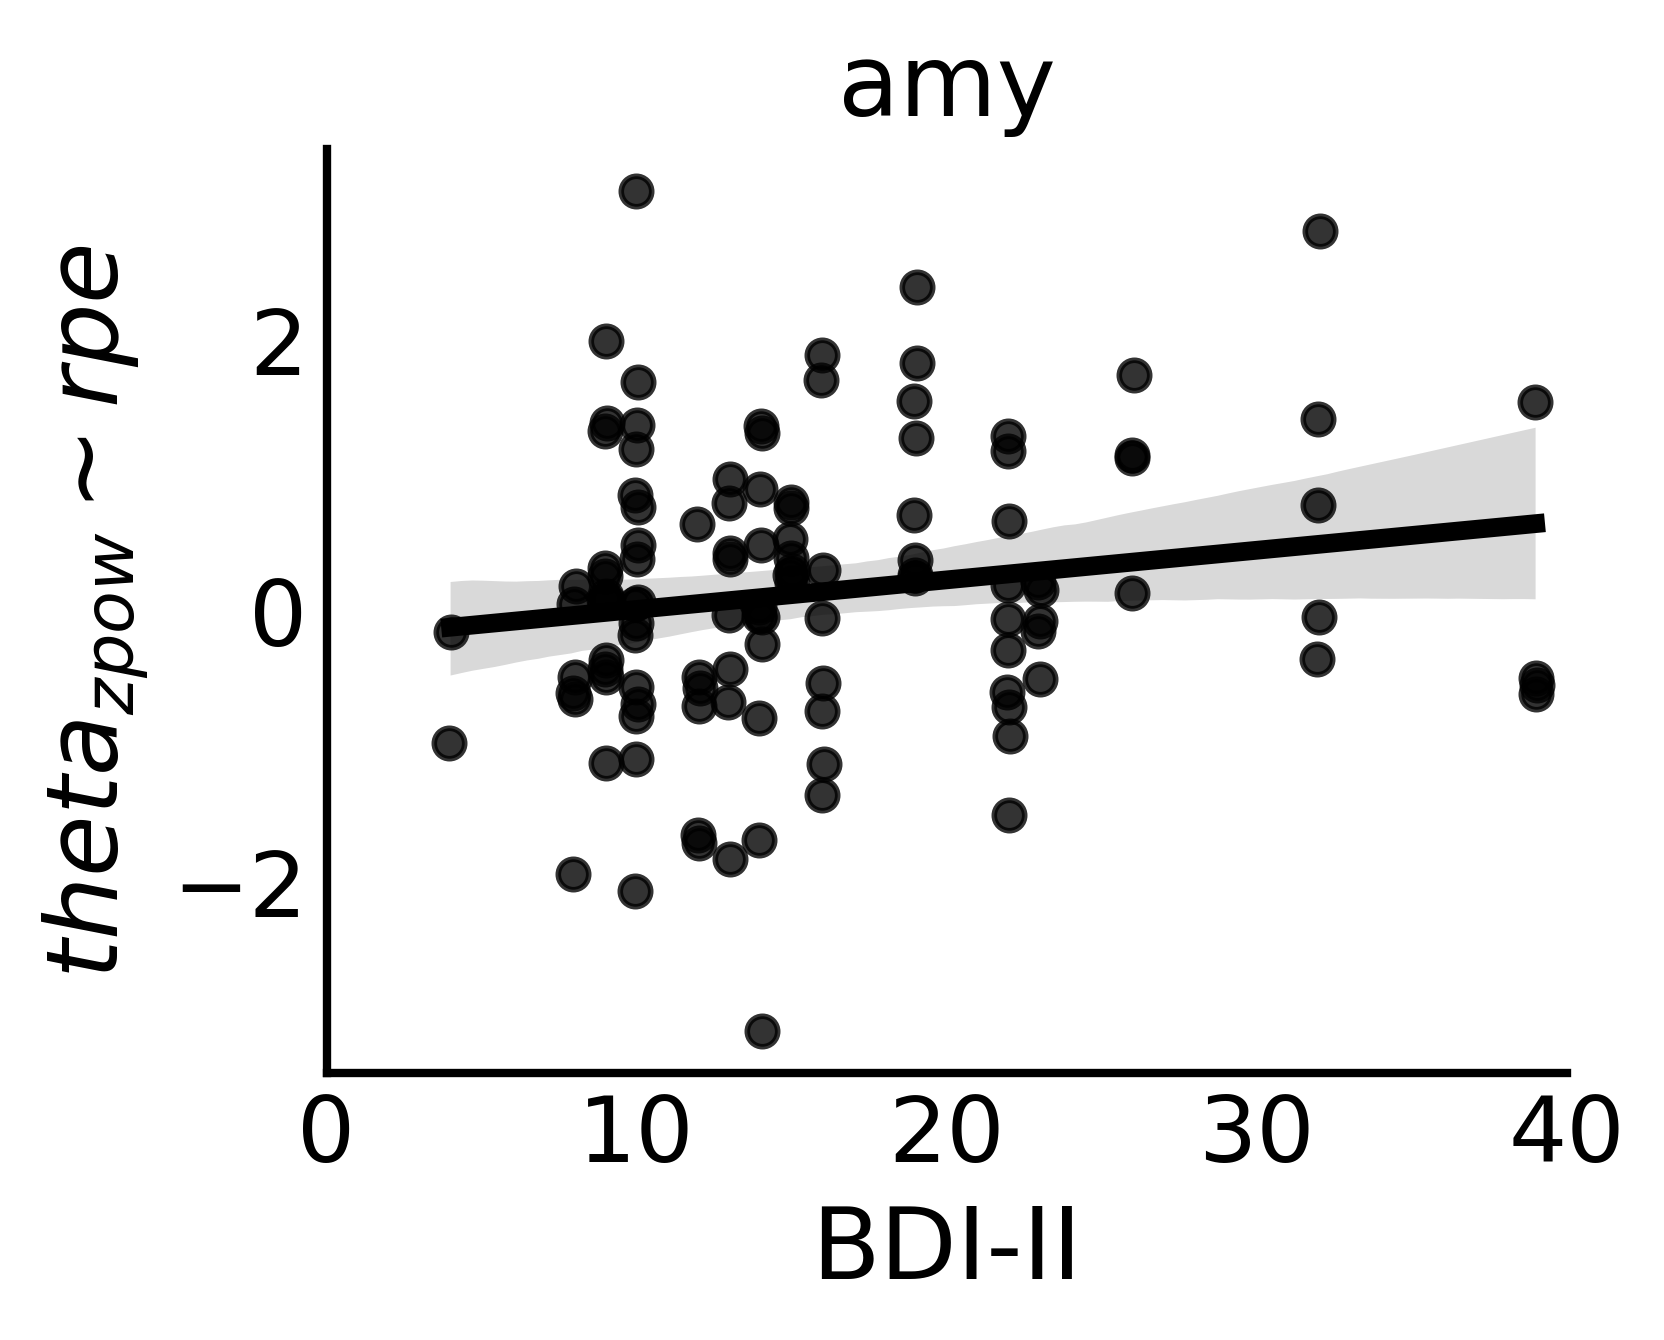

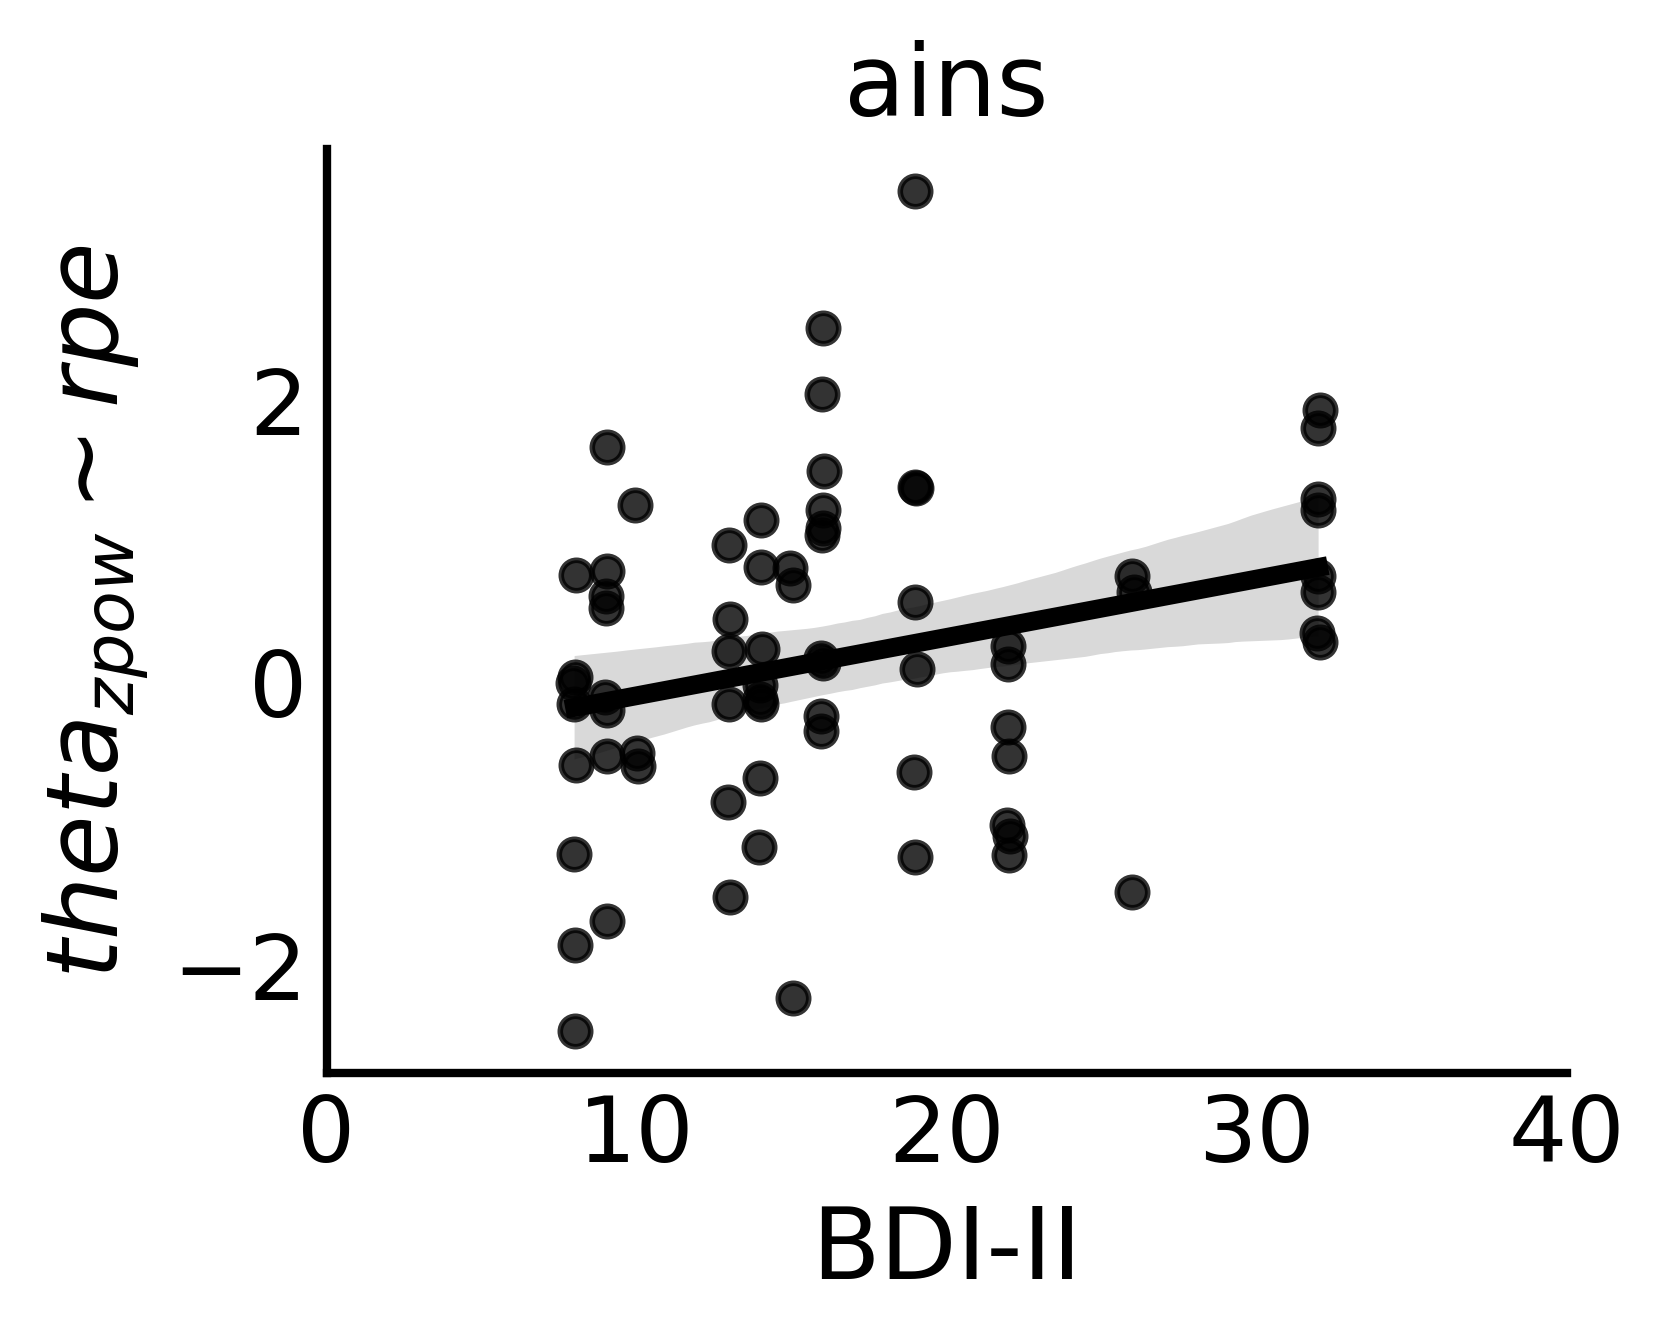

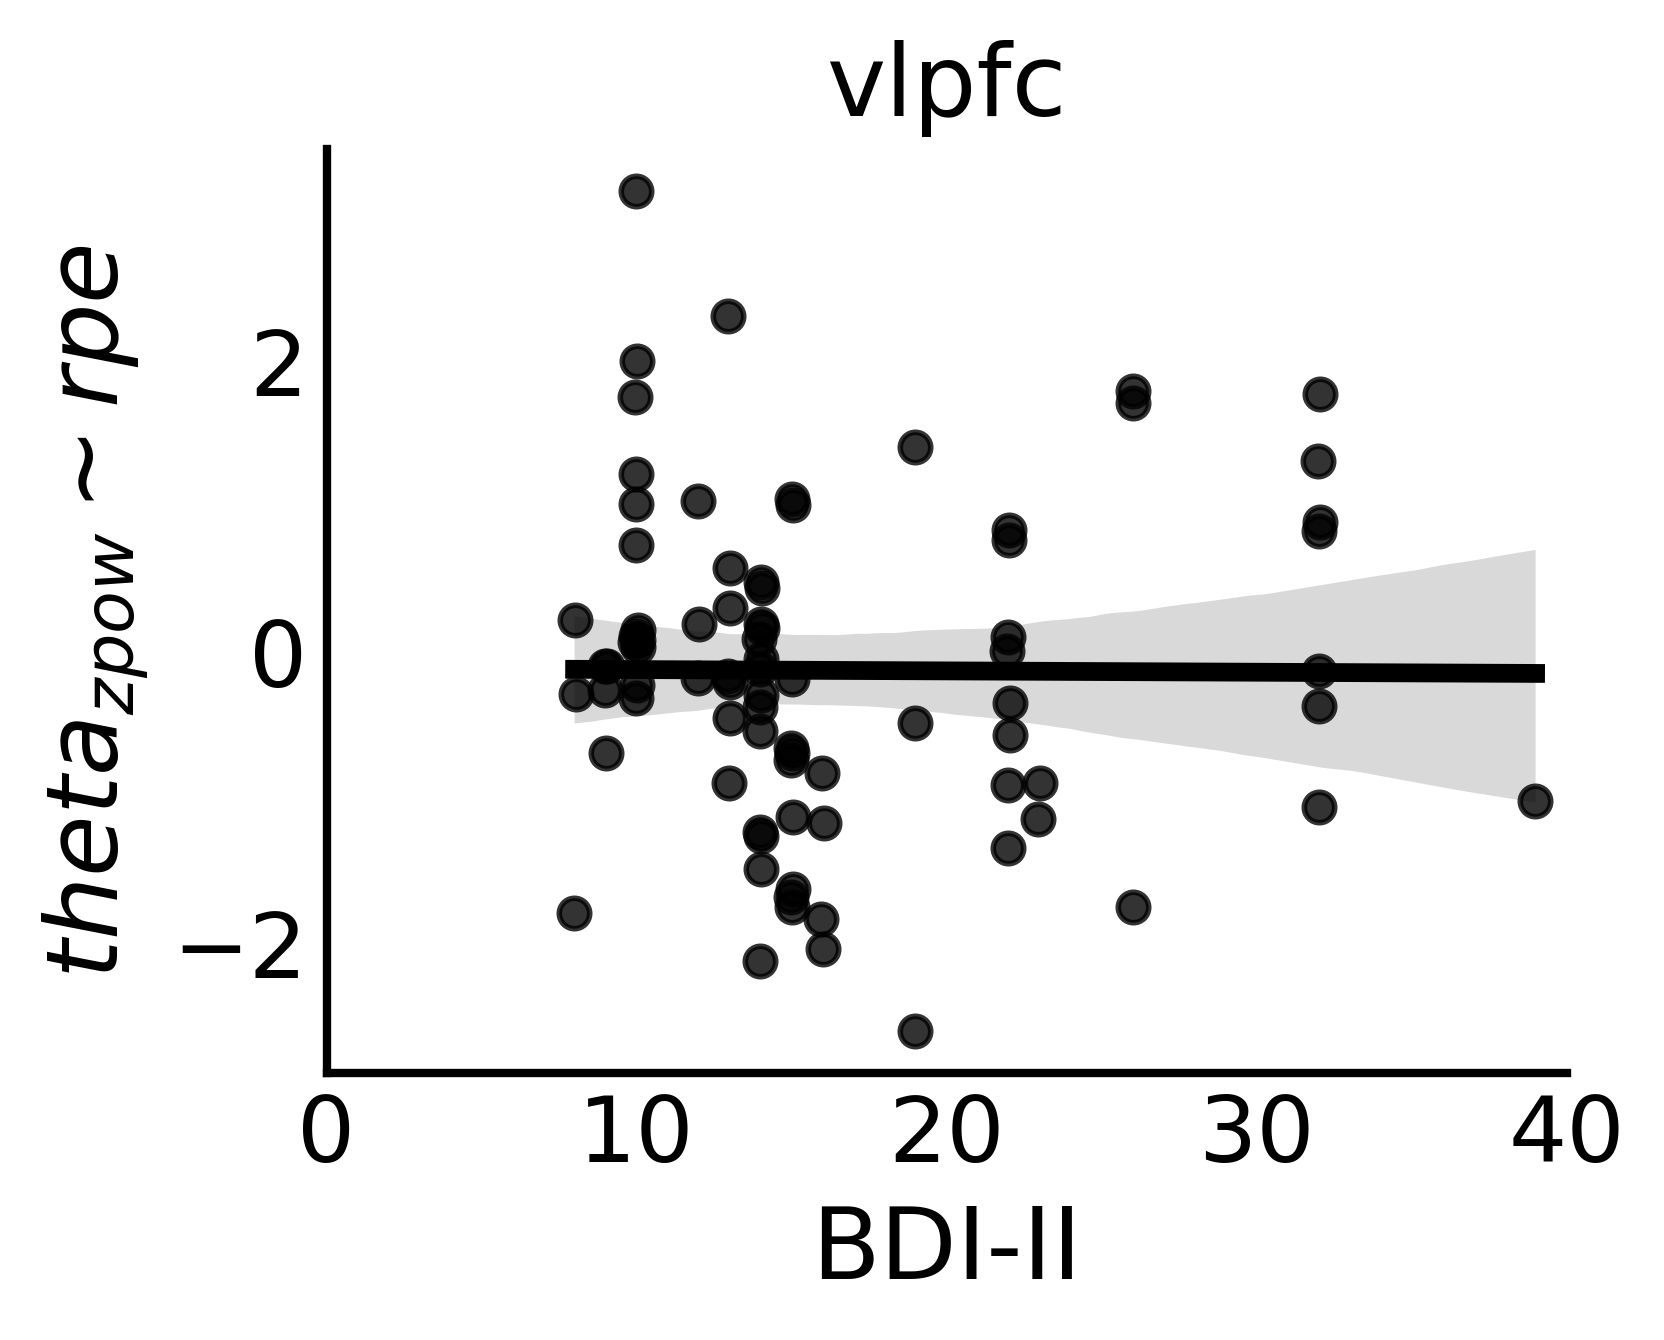

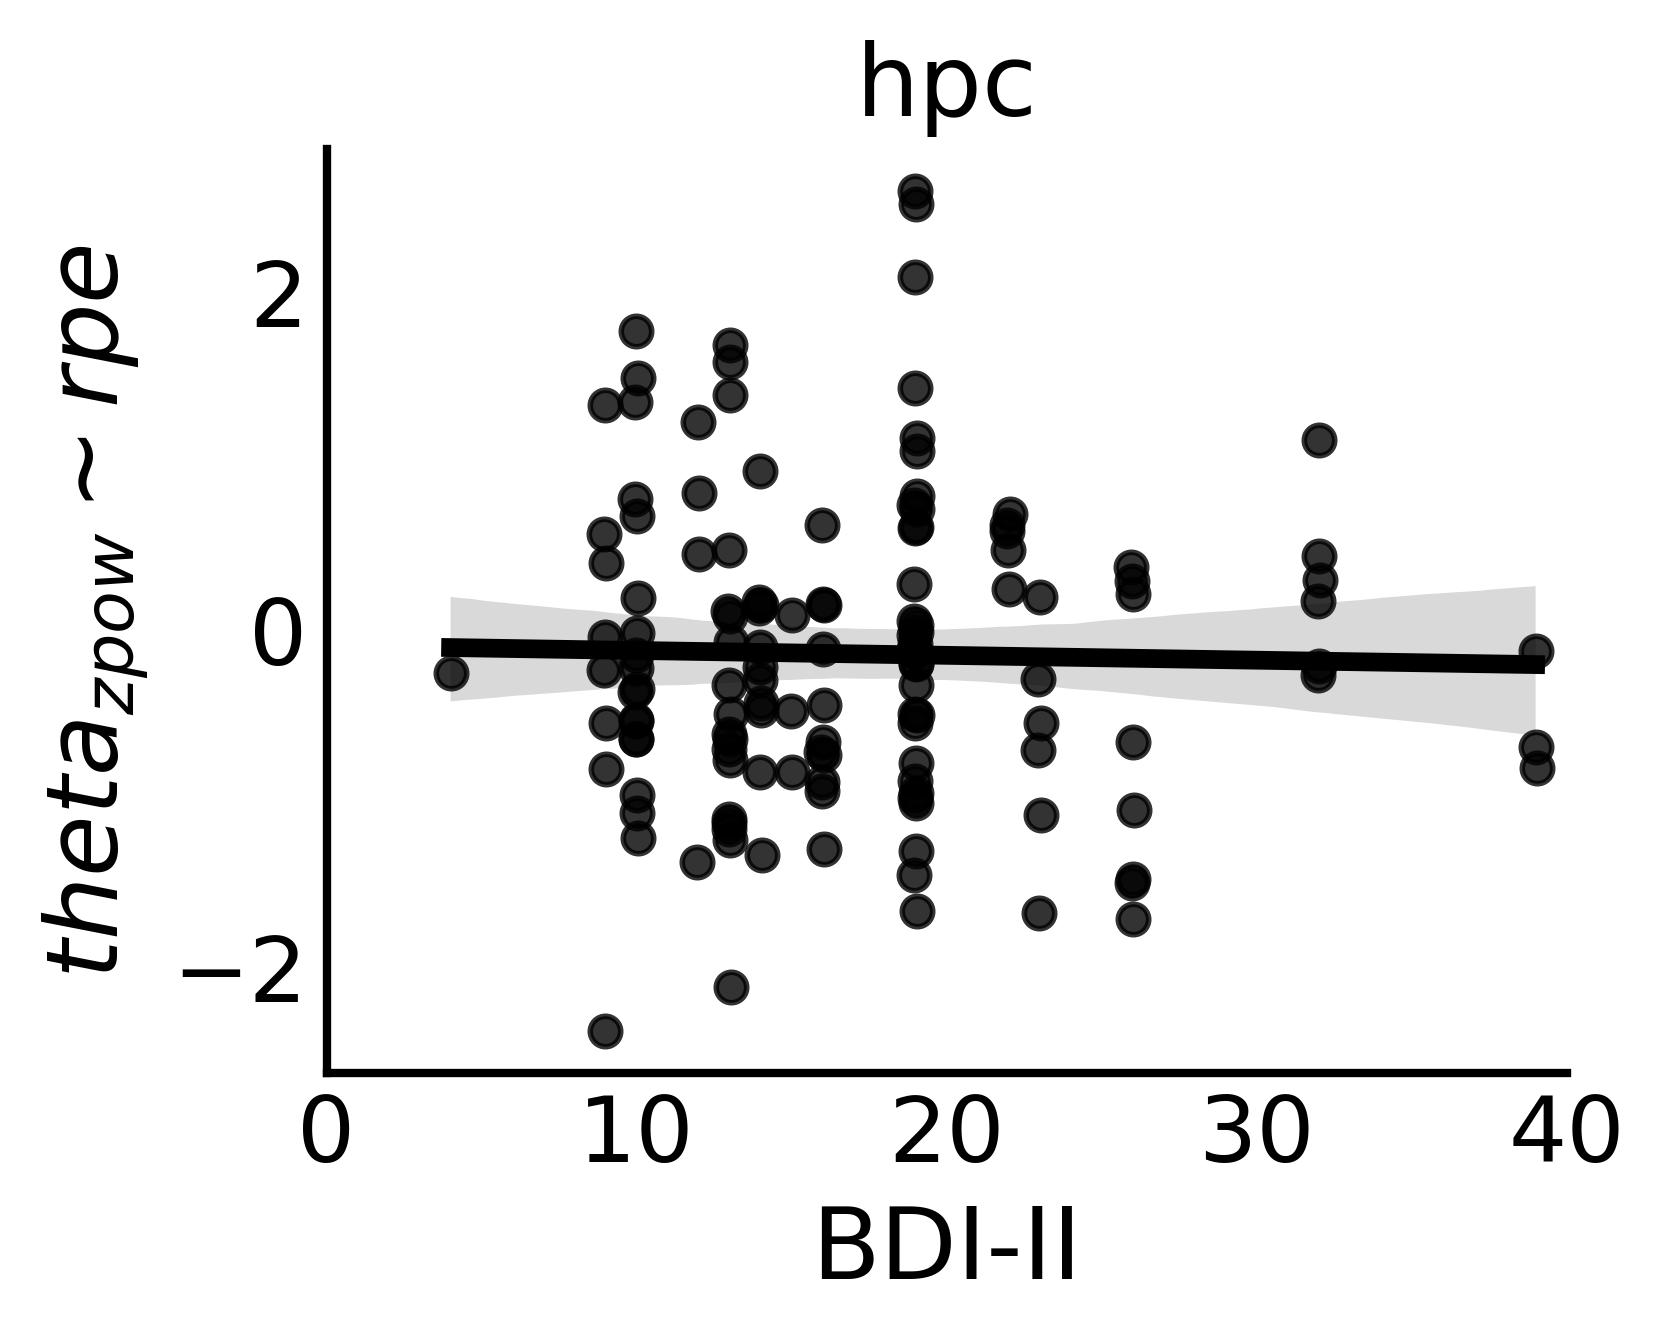

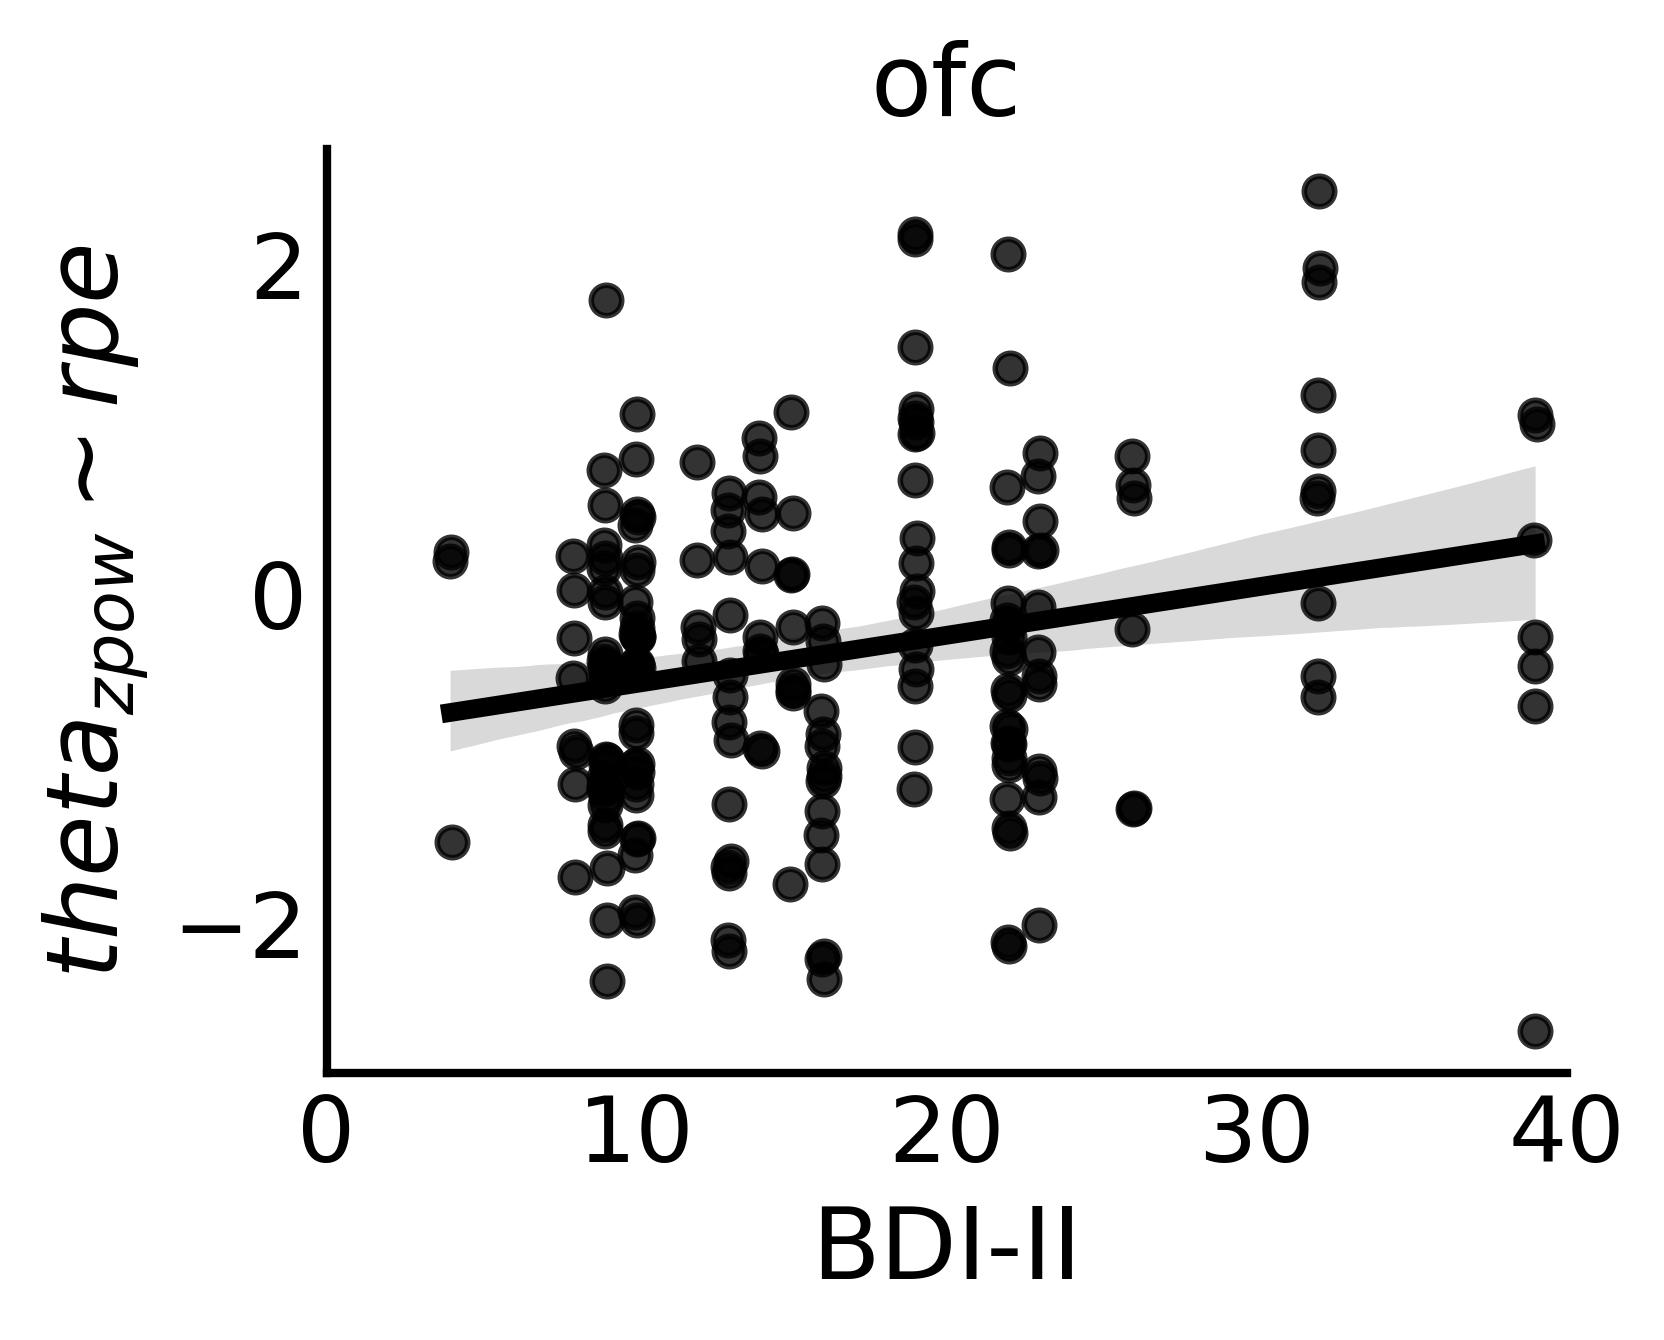

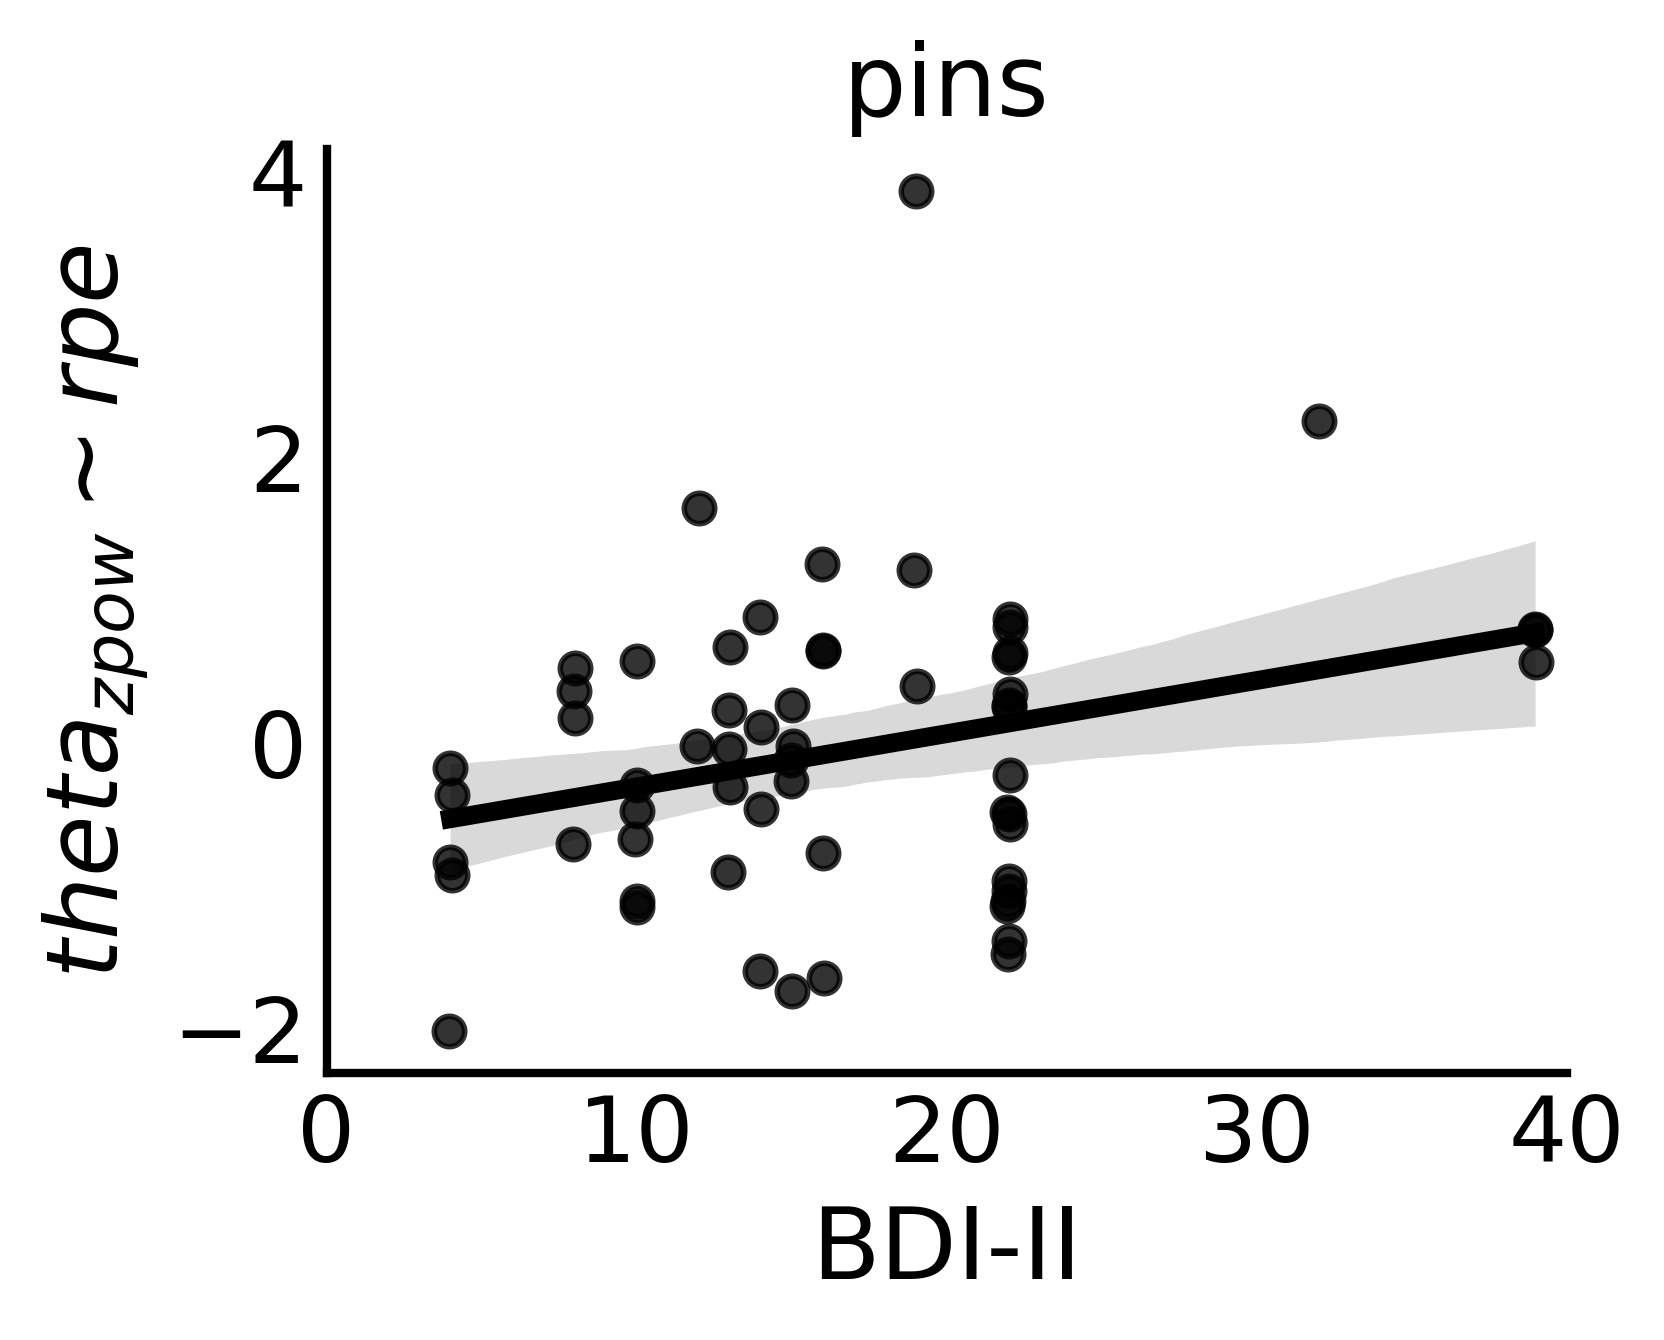

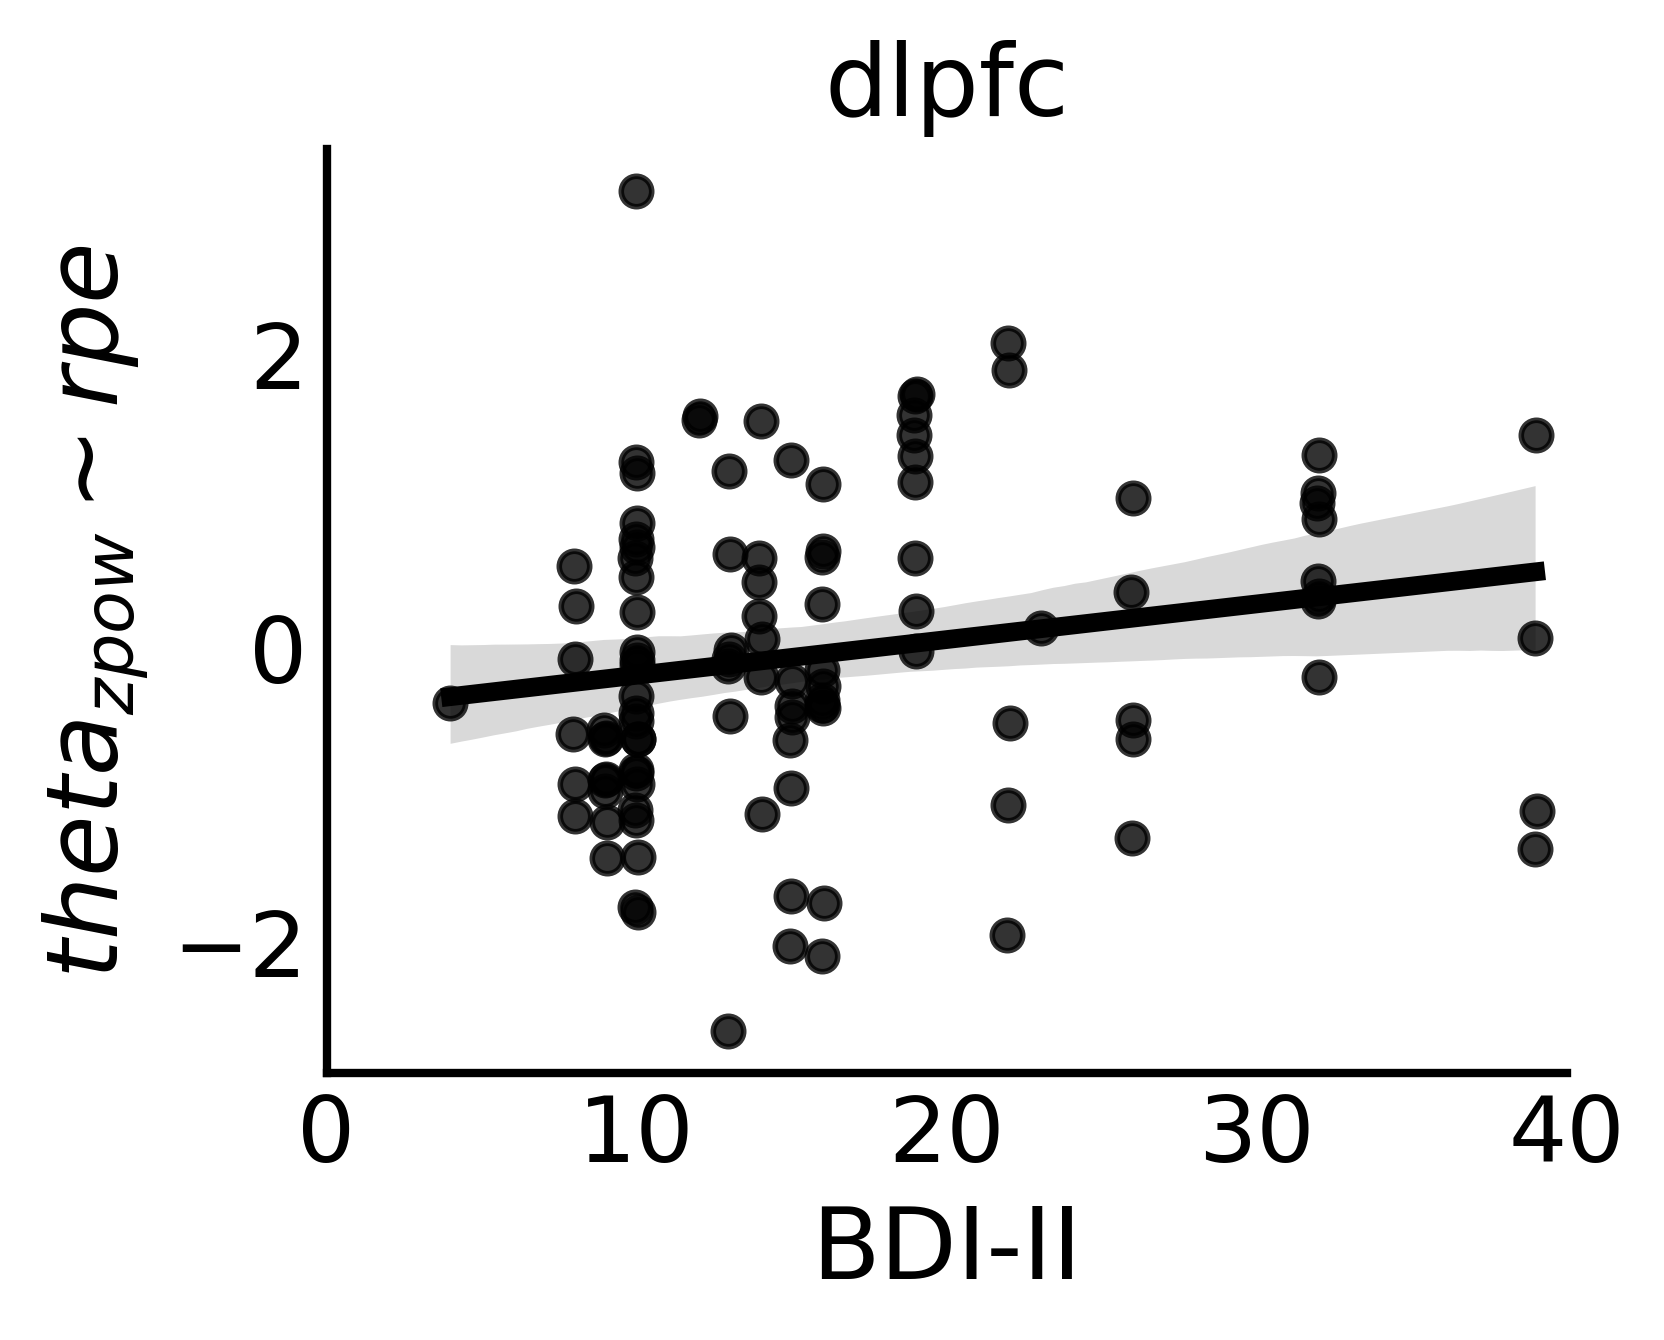

In [43]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_errormodels-bdi_rpe_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_rpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim rpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [44]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_rpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 01 Oct 2024                                         
Time:                        10:52:20                                         
No. Iterations:                    14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.5069      0.423     36.648     